In [1]:
import sys
sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
import pandas as pd
import datetime as dt
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from distance import distance_calculator
from functools import reduce
from cylindrical_conversion import interp_to_equal_grid,circle,x_y_grid_to_cylindrical
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import xarray as xr
from misc_useful_funcs import multiple_conditions_index_finder
import multiprocessing
import scipy.stats as stats
import time


In [2]:
# precip_list = []
# # for now_it in range(len(all_time_filepaths.loc[case_loop])):
# for case_loop in [27663]:
#     for now_it in range(len(all_time_filepaths.loc[case_loop])):

#         fn = all_time_filepaths.loc[case_loop][now_it]
#         try:
#             f = h5py.File(fn, 'r')
#         except: # If the file is corrupt, remove and re-download
#             os.system('rm ' + fn)
#             os.chdir(fn[0:35])
#             new_url = 'https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/' + fn[26:]
#             os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
#                       + new_url)
#             f = h5py.File(fn, 'r')
#         # Work on precip file
#         groups = [ x for x in f.keys() ]
#         # print(groups)
#         gridMembers = [ x for x in f['Grid'] ]
#         # print(gridMembers)

#         # Get the precipitation, latitude, and longitude variables
#         precip = f['Grid/precipitation'][0][:][:]
#         precip = np.transpose(precip)
#         precip[precip<-999]=np.nan

#         theLats = f['Grid/lat'][:]
#         theLons = f['Grid/lon'][:]
#         x, y = np.float32(np.meshgrid(theLons, theLats))

#         precip_list.append(precip)
#         f.close()

#     # For now, we take a mean. Might need a different filter in the future
#     precip_mean = np.mean(np.asarray(precip_list),axis=0)

#     centering_lat = filtered_cases.loc[case_loop]['LAT']
#     centering_lon_orig = filtered_cases.loc[case_loop]['LON'] # Degrees W
#     if centering_lon_orig < 180: # Adjust lon from degrees W to -180 to 180
#         centering_lon = centering_lon_orig * -1
#     elif centering_lon_orig >= 180:
#         # centering_lon = centering_lon + 360
#         centering_lon = 360 - centering_lon_orig
# #--------------------------------------------------------------------------

#     x_roll = np.roll(x,1800,axis=1)
#     y_roll = np.roll(y,1800,axis=1)
#     precip_roll =  np.roll(precip_mean,1800,axis=1)

#     # Create a mask for the negative values
#     mask = x_roll < 0

#     # Add 360 to the negative values. This makes the lon grid edge not be at IDL. It is actually, degrees E from 0 to 360
#     x_roll[mask] += 360
    
#     if (curr_basin == 'EP') | (curr_basin == 'WP') | (curr_basin == 'CP'):
#         x = x_roll
#         precip_mean = precip_roll
#         if centering_lon_orig < 180:
#             centering_lon = 180+(180-(-1*centering_lon_orig)) # converts to 0 to 360, since these cases are shifted

# #--------------------------------------------------------------------------
#     distance_arr = distance_calculator(x, y,(centering_lon,centering_lat))

#     abs_dist_arr = (abs(distance_arr))

#     min_dist_ind = np.where(abs_dist_arr == np.nanmin(abs_dist_arr))

#     # Slice arrays to within 100 indices of interpolated best-track center
    
#     sliced_lon_grid = x[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]
#     sliced_lat_grid = y[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]
#     sliced_precip = precip_mean[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]


In [3]:
# plt.pcolormesh(sliced_lon_grid,sliced_lat_grid,sliced_precip)
# plt.scatter(centering_lon,centering_lat)
# (centering_lon,centering_lat)

In [4]:
# plt.contourf(x,y,distance_arr)
# plt.colorbar()
# plt.scatter(centering_lon,centering_lat)
# plt.vlines(180,ymin=-90,ymax=90,)

In [5]:
# plt.pcolormesh(sliced_lon_grid,sliced_lat_grid,sliced_precip)
# plt.colorbar()
# plt.scatter(centering_lon,centering_lat)

In [6]:
def process_imerg_all(iteration,case_loop,case_loop_list,all_last_slices,all_time_filepaths,filtered_cases,curr_basin):
    # # Open IMERG
    # import h5py
    # import os
    # import numpy as np
    # import sys
    # sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
    # from distance import distance_calculator
    # from cylindrical_conversion import interp_to_equal_grid,circle,x_y_grid_to_cylindrical
    # from scipy import ndimage
    # import pandas as pd

    precip_list = []
    for now_it in range(len(all_time_filepaths.loc[case_loop])):
        fn = all_time_filepaths.loc[case_loop][now_it]
        try:
            f = h5py.File(fn, 'r')
        except: # If the file is corrupt, remove and re-download
            os.system('rm ' + fn)
            os.chdir(fn[0:35])
            new_url = 'https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/' + fn[26:]
            os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                      + new_url)
            f = h5py.File(fn, 'r')
        # Work on precip file
        groups = [ x for x in f.keys() ]
        # print(groups)
        gridMembers = [ x for x in f['Grid'] ]
        # print(gridMembers)

        # Get the precipitation, latitude, and longitude variables
        precip = f['Grid/precipitation'][0][:][:]
        precip = np.transpose(precip)
        precip[precip<-999]=np.nan

        theLats = f['Grid/lat'][:]
        theLons = f['Grid/lon'][:]
        x, y = np.float32(np.meshgrid(theLons, theLats))

        precip_list.append(precip)
        f.close()

    # For now, we take a mean. Might need a different filter in the future
    precip_mean = np.mean(np.asarray(precip_list),axis=0)
    
    centering_lat = filtered_cases.loc[case_loop]['LAT']
    centering_lon_orig = filtered_cases.loc[case_loop]['LON'] # Degrees W
    if centering_lon_orig < 180: # Adjust lon from degrees W to -180 to 180
        centering_lon = centering_lon_orig * -1
    elif centering_lon_orig >= 180:
        # centering_lon = centering_lon + 360
        centering_lon = 360 - centering_lon_orig
        
#--------------------------------------------------------------------------

    x_roll = np.roll(x,1800,axis=1)
    y_roll = np.roll(y,1800,axis=1)
    precip_roll =  np.roll(precip_mean,1800,axis=1)

    # Create a mask for the negative values
    mask = x_roll < 0

    # Add 360 to the negative values. This makes the lon grid edge not be at IDL. It is actually, degrees E from 0 to 360
    x_roll[mask] += 360
    if (curr_basin == 'EP') | (curr_basin == 'WP') | (curr_basin == 'CP'):
        x = x_roll
        precip_mean = precip_roll
        if centering_lon_orig < 180:
            centering_lon = 180+(180-(-1*centering_lon)) # converts to 0 to 360, since these cases are shifted
            
    # print([centering_lon_orig,centering_lon,x.min(),x.max()])

#--------------------------------------------------------------------------    
    distance_arr = distance_calculator(x, y,(centering_lon,centering_lat))

    abs_dist_arr = (abs(distance_arr))

    min_dist_ind = np.where(abs_dist_arr == np.nanmin(abs_dist_arr))
    
    # Slice arrays to within 100 indices of interpolated best-track center

    sliced_lon_grid = x[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]

    sliced_lat_grid = y[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]

    sliced_precip = precip_mean[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]

    # NEVER FORGET TO MULTIPLY RADIUS ARRAYS BY DX FOR IMERG PLOTS!!!

    dx = 2
    dy = 2

    # Interpolate IMERG data to equal-distance grid
    # print([iteration,case_loop,sliced_lon_grid,sliced_lat_grid])
    eq_lon_grid,eq_lat_grid,eq_dist_data = interp_to_equal_grid(sliced_lon_grid,sliced_lat_grid,
                                                            sliced_precip,dx = dx,dy=dy)
    
    
    distance_arr_sliced = distance_calculator(eq_lon_grid, eq_lat_grid,(centering_lon,centering_lat))

    abs_dist_arr_sliced = (abs(distance_arr_sliced))

    min_dist_ind_sliced = np.where(abs_dist_arr_sliced == np.nanmin(abs_dist_arr_sliced))

    pts_above = eq_dist_data.shape[0] - min_dist_ind_sliced[0][0]
    y_range = np.arange(-min_dist_ind_sliced[0][0],pts_above) * dy

    pts_right = eq_dist_data.shape[1] - min_dist_ind_sliced[1][0]
    x_range = np.arange(-min_dist_ind_sliced[1][0],pts_right) * dx

    xv, yv = np.meshgrid(x_range, y_range)

    x_range.shape[0],np.where(x_range==0)[0][0]

    x_zero_loc = np.where(x_range==0)[0][0]

    if x_zero_loc > x_range.shape[0]/2:
        x_offset = int(x_range.shape[0]-x_zero_loc)
    elif x_zero_loc <= x_range.shape[0]/2:
        x_offset = x_zero_loc

    y_zero_loc = np.where(y_range==0)[0][0]

    if y_zero_loc > y_range.shape[0]/2:
        y_offset = int(y_range.shape[0]-y_zero_loc)
    elif y_zero_loc <= y_range.shape[0]/2:
        y_offset = y_zero_loc

    x_even_inds = x_range[x_zero_loc-(x_offset-1):x_zero_loc+x_offset+1]
    y_even_inds = y_range[y_zero_loc-(y_offset-1):y_zero_loc+y_offset+1]

    sliced_eq_data_pd = pd.DataFrame(eq_dist_data,columns=x_range,index=y_range)

    evenly_sliced_pd = sliced_eq_data_pd[x_even_inds].loc[y_even_inds]

    x_evenly_sliced, y_evenly_sliced = np.meshgrid(x_even_inds, y_even_inds)
    
    angle_rotate = 90 - filtered_cases.loc[case_loop]['SHTD'] # Convert to math angle for rotation
    
    img_rotate = ndimage.rotate(evenly_sliced_pd, angle_rotate, reshape=False,cval=np.nan,prefilter=False)
    img_rotate_pd = pd.DataFrame(img_rotate,columns=evenly_sliced_pd.columns,index=evenly_sliced_pd.index)

    pd_last_slice = img_rotate_pd[np.arange(-300,300.1,dx)].loc[-300:300]
    x_evenly_last_sliced, y_evenly_last_sliced = np.meshgrid(pd_last_slice.columns, pd_last_slice.index)

    # return [case_loop,pd_last_slice]
    # result_list[iteration] = [case_loop,pd_last_slice]
    case_loop_list[iteration] = case_loop
    all_last_slices[iteration] = pd_last_slice
    


In [7]:
filepaths = ['/Users/acheung/data/SHIPS/all_SHIPs_data_combined_north_atlantic.csv',
            '/Users/acheung/data/SHIPS/all_SHIPs_data_combined_east_pacific.csv',
            '/Users/acheung/data/SHIPS/all_SHIPs_data_combined_central_pacific.csv',
            '/Users/acheung/data/SHIPS/all_SHIPs_data_combined_west_pacific.csv',
            '/Users/acheung/data/SHIPS/all_SHIPs_data_combined_north_indian.csv']

list_of_dfs = []
for file in filepaths:
    df = pd.read_csv(file)
    list_of_dfs.append(df)
combined_df = pd.concat(list_of_dfs, ignore_index=True)
basins = combined_df['Storm_ID'].str[:2]
combined_df.insert(1, 'Basin', basins)

In [8]:
SHIPS = combined_df
# Select only tropical storms
tropical_inds = SHIPS.where(SHIPS['TYPE'] == 1).dropna().index

# Select storms at least 50 km from land

dtl_inds = SHIPS.where(SHIPS['DTL'] >=50).dropna().index

# Select Storm with at least 10 KJ/cm2 OHC

ohc_inds =  SHIPS.where(SHIPS['COHC'] >=10).dropna().index

# Select Storm with at least 40% Mid-level (700–500 hPa) RH

# rhmd_inds =  SHIPS.where(SHIPS['RHMD'] >=40).dropna().index

# result = multiple_conditions_index_finder([tropical_inds,dtl_inds,ohc_inds,rhmd_inds])
result = multiple_conditions_index_finder([tropical_inds,dtl_inds,ohc_inds])

# Cases that meet all criteria set above
filtered_cases = SHIPS.loc[result]
filtered_cases['Time'] = pd.to_datetime(filtered_cases['Time'])

SHIPS_dts = pd.to_datetime(SHIPS['Time'])

In [9]:
# Select storms before downloading IMERG

# filepaths = ['/Users/acheung/data/SHIPS/all_SHIPs_data_combined_north_atlantic.csv',
#             '/Users/acheung/data/SHIPS/all_SHIPs_data_combined_east_pacific.csv',
#             '/Users/acheung/data/SHIPS/all_SHIPs_data_combined_central_pacific.csv',
#             '/Users/acheung/data/SHIPS/all_SHIPs_data_combined_west_pacific.csv',
#             '/Users/acheung/data/SHIPS/all_SHIPs_data_combined_north_indian.csv']

for curr_basin in combined_df['Basin'].unique():
# for curr_basin in [combined_df['Basin'].unique()[2]]:
    
#     if current_path == '/Users/acheung/data/SHIPS/all_SHIPs_data_combined_north_atlantic.csv':
#         curr_basin = 'NA'
#     elif current_path == '/Users/acheung/data/SHIPS/all_SHIPs_data_combined_east_pacific.csv':
#         curr_basin = 'EP'
#     elif current_path == '/Users/acheung/data/SHIPS/all_SHIPs_data_combined_central_pacific.csv':
#         curr_basin = 'CP'
#     elif current_path == '/Users/acheung/data/SHIPS/all_SHIPs_data_combined_west_pacific.csv':
#         curr_basin = 'WP'
#     elif current_path == '/Users/acheung/data/SHIPS/all_SHIPs_data_combined_north_indian.csv':
#         curr_basin = 'NI'
    print('Currently working on Basin: ' + curr_basin)

#     SHIPS = pd.read_csv(current_path)

#     SHIPS = combined_df.where(combined_df['Basin'] == curr_basin).dropna()

#     # Select only tropical storms
#     tropical_inds = SHIPS.where(SHIPS['TYPE'] == 1).dropna().index

#     # Select storms at least 50 km from land

#     dtl_inds = SHIPS.where(SHIPS['DTL'] >=50).dropna().index

#     # Select Storm with at least 10 KJ/cm2 OHC

#     ohc_inds =  SHIPS.where(SHIPS['COHC'] >=10).dropna().index

    # Select Storm with at least 40% Mid-level (700–500 hPa) RH

    # rhmd_inds =  SHIPS.where(SHIPS['RHMD'] >=40).dropna().index

    # result = multiple_conditions_index_finder([tropical_inds,dtl_inds,ohc_inds,rhmd_inds])
    # result = multiple_conditions_index_finder([tropical_inds,dtl_inds,ohc_inds])

    # Cases that meet all criteria set above
    filtered_cases_now_basin = filtered_cases.where(filtered_cases['Basin'] == curr_basin).dropna()

    SHIPS_dts = pd.to_datetime(SHIPS['Time'])
# d1 = dt.datetime(2022,9,1)M# points_in_time = SHIPS_dts.where((SHIPS_dts > d1) & (SHIPS_dts < d2)).dropna()

# SHIPS.loc[points_in_time.index]['TYPE']



    # Download IMERG Data
    timedeltas = [-60,-30,0,30] # zero is 0 to 30 minutes and thirty is 30 mins to 1 h
    # timedeltas = [0] # zero is 0 to 30 minutes and thirty is 30 mins to 1 h

    filepaths = []
    desired_time_list = []
    for i in filtered_cases_now_basin.index:
        curr_time_filepaths = []
        for times in timedeltas:
            # current_dt_obj = dt.datetime.strptime(filtered_cases_now_basin['Time'][i],'%Y-%m-%d %H:%M:%S')
            current_dt_obj = filtered_cases_now_basin['Time'][i]

            time_desired = current_dt_obj + dt.timedelta(minutes=times)
    #         print(i,current_dt_obj,time_desired)

            year = time_desired.year
            day_of_year = time_desired.strftime('%j')
            day_stripped = time_desired.strftime('%Y%m%d')
            time_stripped = time_desired.strftime('%H%M%S')
            min_of_day = str(time_desired.hour*60 + time_desired.minute).zfill(4)
            end_time_stripped = (time_desired+dt.timedelta(minutes=29,seconds=59)).strftime('%H%M%S')

            # If IMERG file does not exist, download it
            IMERG_file_path = '/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year+'/'+\
                '3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+'-E'+end_time_stripped+\
                '.'+min_of_day+'.V07B.HDF5'
            curr_time_filepaths.append(IMERG_file_path)
            # print(IMERG_file_path)
            # print(os.path.exists(IMERG_file_path))

                # If day directory does not exist, make day directory
            if os.path.exists('/Users/acheung/data/IMERG/'+str(year)) == False:
                os.mkdir('/Users/acheung/data/IMERG/'+str(year))

            if os.path.exists('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year) == False:
                os.mkdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

            if os.path.exists(IMERG_file_path) == False:
                url_desired = "https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/"\
                    +str(year)+'/'+day_of_year+'/'+'3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+\
                    '-E'+end_time_stripped+'.'+min_of_day+'.V07B.HDF5'
                os.chdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

                os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                          + url_desired)
        filepaths.append(curr_time_filepaths)
        desired_time_list.append(current_dt_obj)

    all_time_filepaths = pd.DataFrame(filepaths)
    all_time_filepaths.index = filtered_cases_now_basin.index

    # case_loop_list = []
    # all_last_slices = []

    all_loop_inds = range(len(all_time_filepaths.index.values))
    if curr_basin == 'CP':
        split_indices = np.array_split(all_loop_inds, 5)
    else:        
        split_indices = np.array_split(all_loop_inds, 100)

    if __name__ == "__main__": # Run multiprocesses
        manager = multiprocessing.Manager()
        case_loop_list = manager.dict()
        all_last_slices = manager.dict()

        # for case_loop in all_time_filepaths.index.values: # Run all
        for split_now in range(len(split_indices)):
            start_time = time.time()

            jobs = []
            for iteration in split_indices[split_now]:
                case_loop = all_time_filepaths.index.values[iteration]
                p = multiprocessing.Process(target=process_imerg_all, 
                                            args=(iteration,case_loop,
                                                  case_loop_list,all_last_slices,
                                                  all_time_filepaths,filtered_cases_now_basin,curr_basin))
                jobs.append(p)
                p.start()

            for proc in jobs:
                proc.join()

            end_time = time.time()
            elapsed_time = end_time - start_time
            print(split_indices[split_now][0],split_indices[split_now][-1],all_loop_inds)
            print(f"Elapsed time: {elapsed_time} seconds")


    all_last_slices_xr = xr.DataArray(all_last_slices.values(),dims=["case","x", "y"],coords=dict(
            x=(["x"], all_last_slices.values()[0].columns),
            y=(["y"], all_last_slices.values()[0].index),
            case=(case_loop_list.values()))
        )
    all_last_slices_xr = all_last_slices_xr.sortby('case')
    data_with_coordinate_info = all_last_slices_xr.assign_coords(time=('case', desired_time_list),atcf_id=('case',filtered_cases_now_basin['Storm_ID']),basin=('case',[curr_basin] * len(all_last_slices_xr)))
    data_with_coordinate_info.to_netcdf('/Users/acheung/data/Composite_Data/imerg_'+curr_basin+'_composites.nc')


Currently working on Basin: AL
0 62 range(0, 6251)
Elapsed time: 8.090586185455322 seconds
63 125 range(0, 6251)
Elapsed time: 7.390259027481079 seconds
126 188 range(0, 6251)
Elapsed time: 8.461229085922241 seconds
189 251 range(0, 6251)
Elapsed time: 9.031808137893677 seconds
252 314 range(0, 6251)
Elapsed time: 9.837985515594482 seconds
315 377 range(0, 6251)
Elapsed time: 7.616722345352173 seconds
378 440 range(0, 6251)
Elapsed time: 9.440443992614746 seconds
441 503 range(0, 6251)
Elapsed time: 10.31481146812439 seconds
504 566 range(0, 6251)
Elapsed time: 10.25436544418335 seconds
567 629 range(0, 6251)
Elapsed time: 8.874839067459106 seconds
630 692 range(0, 6251)
Elapsed time: 11.190603017807007 seconds
693 755 range(0, 6251)
Elapsed time: 9.352708339691162 seconds
756 818 range(0, 6251)
Elapsed time: 7.810553550720215 seconds
819 881 range(0, 6251)
Elapsed time: 9.448508262634277 seconds
882 944 range(0, 6251)
Elapsed time: 6.781206846237183 seconds
945 1007 range(0, 6251)
Ela

--2025-06-24 14:17:05--  https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2002/301/3B-HHR.MS.MRG.3IMERG.20021028-S063000-E065959.0390.V07B.HDF5
Resolving gpm1.gesdisc.eosdis.nasa.gov (gpm1.gesdisc.eosdis.nasa.gov)... 198.118.197.50, 2001:4d0:241a:4041::50
Connecting to gpm1.gesdisc.eosdis.nasa.gov (gpm1.gesdisc.eosdis.nasa.gov)|198.118.197.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7383077 (7.0M) [application/x-troff-ms]
Saving to: ‘3B-HHR.MS.MRG.3IMERG.20021028-S063000-E065959.0390.V07B.HDF5’

     0K .......... .......... .......... .......... ..........  0% 19.0M 0s
    50K .......... .......... .......... .......... ..........  1% 25.5M 0s
   100K .......... .......... .......... .......... ..........  2% 22.3M 0s
   150K .......... .......... .......... .......... ..........  2%  133M 0s
   200K .......... .......... .......... .......... ..........  3%  117M 0s
   250K .......... .......... .......... .......... ..........  4% 52.

0 96 range(0, 483)
Elapsed time: 20.946390867233276 seconds
97 193 range(0, 483)
Elapsed time: 20.45521640777588 seconds
194 290 range(0, 483)
Elapsed time: 20.657795906066895 seconds
291 386 range(0, 483)
Elapsed time: 20.408311367034912 seconds
387 482 range(0, 483)
Elapsed time: 20.408895015716553 seconds
Currently working on Basin: WP
0 87 range(0, 8756)
Elapsed time: 17.087706327438354 seconds
88 175 range(0, 8756)
Elapsed time: 16.832489013671875 seconds
176 263 range(0, 8756)
Elapsed time: 16.865615606307983 seconds
264 351 range(0, 8756)
Elapsed time: 16.755799531936646 seconds
352 439 range(0, 8756)
Elapsed time: 17.12311339378357 seconds
440 527 range(0, 8756)
Elapsed time: 16.728636026382446 seconds
528 615 range(0, 8756)
Elapsed time: 16.688772678375244 seconds
616 703 range(0, 8756)
Elapsed time: 16.66117215156555 seconds
704 791 range(0, 8756)
Elapsed time: 16.82714295387268 seconds
792 879 range(0, 8756)
Elapsed time: 16.7091965675354 seconds
880 967 range(0, 8756)
Elaps

In [9]:
composite_paths = ['/Users/acheung/data/Composite_Data/imerg_AL_composites.nc',
                  '/Users/acheung/data/Composite_Data/imerg_EP_composites.nc',
                  '/Users/acheung/data/Composite_Data/imerg_CP_composites.nc',
                  '/Users/acheung/data/Composite_Data/imerg_WP_composites.nc',
                  '/Users/acheung/data/Composite_Data/imerg_IO_composites.nc']

In [10]:
imerg_cases = xr.open_mfdataset(composite_paths,chunks={"case": 30},parallel=True)['__xarray_dataarray_variable__']

In [13]:
# Identify times with 20 kt/12 h increases

boo_list = []
for f_i in filtered_cases.index:
    current_storm_time = filtered_cases.loc[f_i]
    current_vmax = filtered_cases['VMAX'].where(filtered_cases['Storm_ID'] == current_storm_time['Storm_ID']).dropna()
    
    # Check to see intensity 12 h later exists, if so, then calculate difference
    if sum(current_vmax.index.isin([current_storm_time.name + 2])) == 0: # No value 12 h later
        ri_boo = 0
        intensity_12_h_change = np.nan
    else: # Has value 12 h later, check RI or not
        intensity_12_h_change = current_vmax[current_storm_time.name + 2] - current_vmax[current_storm_time.name]
        if intensity_12_h_change >= 40: # 20 or greater
            extreme_ri_boo = 1
        else:
            extreme_ri_boo = 0
        if intensity_12_h_change >= 20: # 20 or greater
            ri_boo = 1
        else:
            ri_boo = 0
        
        if (intensity_12_h_change < 20) & (intensity_12_h_change > 5): # 10, 15
            slowly_boo = 1
        else:
            slowly_boo = 0
        
        if (intensity_12_h_change >= -5) & (intensity_12_h_change <=5): # -5, 0, 5
            ss_boo = 1
        else:
            ss_boo = 0
        
        if intensity_12_h_change <-5: # less than -5
            weakening_boo = 1
        else:
            weakening_boo = 0
            
            
    boo_list.append([ri_boo,slowly_boo,ss_boo,weakening_boo,intensity_12_h_change,extreme_ri_boo])
    
boolean_pd = pd.DataFrame(boo_list,index=filtered_cases.index,columns=['RI Boolean','Slowly-Intensifying Boolean',
                                                                  'Steady-State Boolean','Weakening Boolean','12-h Intensity Change',
                                                                       'Extreme RI Boolean'])

filtered_with_boo = pd.concat([filtered_cases,boolean_pd],axis=1)
filtered_with_boo_multi_index = filtered_with_boo.set_index(['Time','Storm_ID','Name'], append=True)


In [14]:
filtered_cases

,Time,Basin,Storm_ID,Name,LAT,LON,TYPE,VMAX,SHRD,SHTD,VMPI,COHC,RSST,RHLO,RHMD,IR00,DTL
0,1998-07-27 12:00:00,AL,AL011998,ALEX,11.3,25.4,1,25,1.7,320,126,13,27.4,68,67,26,934
1,1998-07-27 18:00:00,AL,AL011998,ALEX,11.7,27.2,1,25,4.4,31,127,14,27.4,69,67,26,1099
2,1998-07-28 00:00:00,AL,AL011998,ALEX,12.2,29.2,1,25,5.9,5,130,16,27.4,71,68,22,1292
3,1998-07-28 06:00:00,AL,AL011998,ALEX,12.6,31.3,1,25,5.6,34,125,17,27.2,71,69,30,1506
4,1998-07-28 12:00:00,AL,AL011998,ALEX,12.9,33.3,1,30,6.1,66,119,13,27.1,71,70,30,1714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37722,2021-12-04 06:00:00,IO,IO052021,JAWAD,16.3,275.0,1,35,16.4,296,123,36,28.5,69,58,30,241
37723,2021-12-04 12:00:00,IO,IO052021,JAWAD,16.8,274.7,1,35,20.1,302,120,33,28.4,70,57,30,220
37724,2021-12-04 18:00:00,IO,IO052021,JAWAD,17.1,274.5,1,30,21.4,320,120,33,28.4,68,54,2,209
37725,2021-12-05 00:00:00,IO,IO052021,JAWAD,17.5,274.2,1,30,23.5,340,120,32,28.3,70,54,14,196


In [15]:
RI_cases_examined = filtered_with_boo.where(filtered_with_boo['RI Boolean'] == 1).dropna()

RI_boo_times = RI_cases_examined['Time']

RI_counter_list = []
current_duration_list = []

for now_id in RI_cases_examined['Storm_ID'].unique():
    current_RI_case_data = RI_cases_examined.where(RI_cases_examined['Storm_ID'] == now_id).dropna()
    current_RI_counter = 1 # Resets the counter for every storm
    current_duration = 0 
    for RI_indexing in range(len(current_RI_case_data)):
        if RI_indexing == 0: # For the first element, this is the first RI point
            current_RI_counter = current_RI_counter + 0
            current_duration = current_duration + 0
        
        elif RI_indexing > 0:
            backward_time_boo = (current_RI_case_data.iloc[RI_indexing]['Time'] - 
                                  current_RI_case_data.iloc[RI_indexing-1]['Time']) == dt.timedelta(hours=6)
            if backward_time_boo == True:
                current_RI_counter = current_RI_counter + 0
                current_duration = current_duration + 6

            elif backward_time_boo == False: # New RI Found 
                current_RI_counter = current_RI_counter + 1
                current_duration = 0

        RI_counter_list.append(current_RI_counter)
        current_duration_list.append(current_duration)
RI_cases_with_RI_Number = pd.concat([RI_cases_examined,pd.DataFrame(RI_counter_list,
                                                                    index = RI_cases_examined.index,columns=['RI-Number'])],axis=1)

RI_cases_with_duration = pd.concat([RI_cases_with_RI_Number,pd.DataFrame(current_duration_list,
                                                                    index = RI_cases_examined.index,columns=['RI-Duration'])],axis=1)



In [16]:
# Weak indices
weak_storm_indices = filtered_cases.where((filtered_cases['VMAX'] <= 65) & (filtered_cases['VMAX'] > 0)).dropna().index
# Strong indices
strong_storm_indices = filtered_cases.where((filtered_cases['VMAX'] > 65)).dropna().index

# Shear indices
weak_shear_indices = filtered_cases.where(filtered_cases['SHRD'] < 10).dropna().index
moderate_shear_indices = filtered_cases.where((filtered_cases['SHRD'] >= 10) & (filtered_cases['SHRD'] < 20)).dropna().index
strong_shear_indices = filtered_cases.where(filtered_cases['SHRD'] >= 20).dropna().index

# Extreme RI Indices
Extreme_RI_indices = filtered_with_boo.where(filtered_with_boo['Extreme RI Boolean'] == 1).dropna().index
Non_Extreme_RI_indices = filtered_with_boo.where(filtered_with_boo['Extreme RI Boolean'] == 0).dropna().index

# RI Indices
RI_indices = filtered_with_boo.where(filtered_with_boo['RI Boolean'] == 1).dropna().index
Non_RI_indices = filtered_with_boo.where(filtered_with_boo['RI Boolean'] == 0).dropna().index

# Slowly-Intensifying Indices
Slowly_intensifying_indices = filtered_with_boo.where(filtered_with_boo['Slowly-Intensifying Boolean'] == 1).dropna().index
Non_Slowly_intensifying_indices = filtered_with_boo.where(filtered_with_boo['Slowly-Intensifying Boolean'] == 0).dropna().index

# Steady-State Indices
SS_indices = filtered_with_boo.where(filtered_with_boo['Steady-State Boolean'] == 1).dropna().index
Non_SS_indices = filtered_with_boo.where(filtered_with_boo['Steady-State Boolean'] == 0).dropna().index

# Weakening Indices
Weakening_indices = filtered_with_boo.where(filtered_with_boo['Weakening Boolean'] == 1).dropna().index
Non_Weakening_indices = filtered_with_boo.where(filtered_with_boo['Weakening Boolean'] == 0).dropna().index



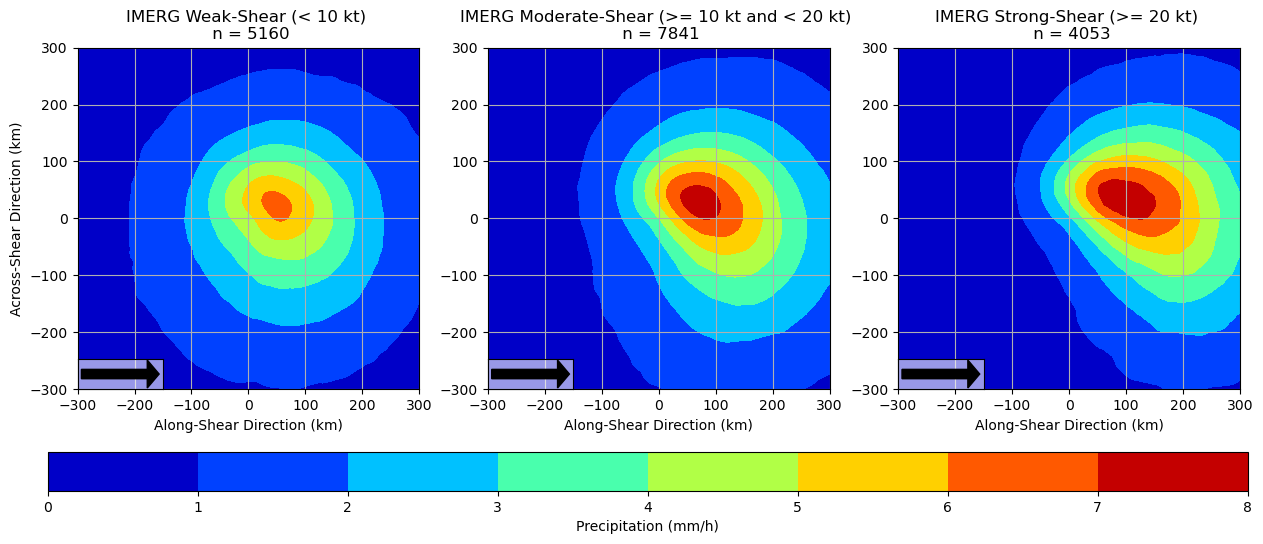

In [17]:
weak_storm_and_weak_shear_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,weak_shear_indices]))
weak_storm_and_moderate_shear_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,moderate_shear_indices]))
weak_storm_and_strong_shear_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,strong_shear_indices]))


fig = plt.figure(figsize=(15, 5.5)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)

small_shear_cf = ax.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_and_weak_shear_imerg.mean('case'),
                              levels=np.arange(0,8.1,1),cmap='jet')
ax.grid()
ax.set_title('IMERG Weak-Shear (< 10 kt) \n n = ' + str(len(weak_storm_and_weak_shear_imerg)))
ax.set_xlabel('Along-Shear Direction (km)')
ax.set_ylabel('Across-Shear Direction (km)')

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

moderate_shear_cf = ax2.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_and_moderate_shear_imerg.mean('case'),
                              levels=np.arange(0,8.1,1),cmap='jet')
ax2.grid()
ax2.set_title('IMERG Moderate-Shear (>= 10 kt and < 20 kt) \n n = ' + str(len(weak_storm_and_moderate_shear_imerg)))
ax2.set_xlabel('Along-Shear Direction (km)')

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

strong_shear_cf = ax3.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_and_strong_shear_imerg.mean('case'),
                              levels=np.arange(0,8.1,1),cmap='jet')
ax3.grid()
ax3.set_title('IMERG Strong-Shear (>= 20 kt) \n n = ' + str(len(weak_storm_and_strong_shear_imerg)))
ax3.set_xlabel('Along-Shear Direction (km)')

axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

cax = plt.axes([0.105, 0, 0.8, 0.07])
# MAKE SURE COLOR LEVELS OF ALL PLOTS ARE SET EQUALLY!!!
plt.colorbar(strong_shear_cf,cax=cax,label='Precipitation (mm/h)',orientation='horizontal')
plt.savefig('/Users/acheung/data/Figures/Paper_Figures/IMERG_Shear_North_Hemi_Composites.png',dpi=900,bbox_inches='tight')


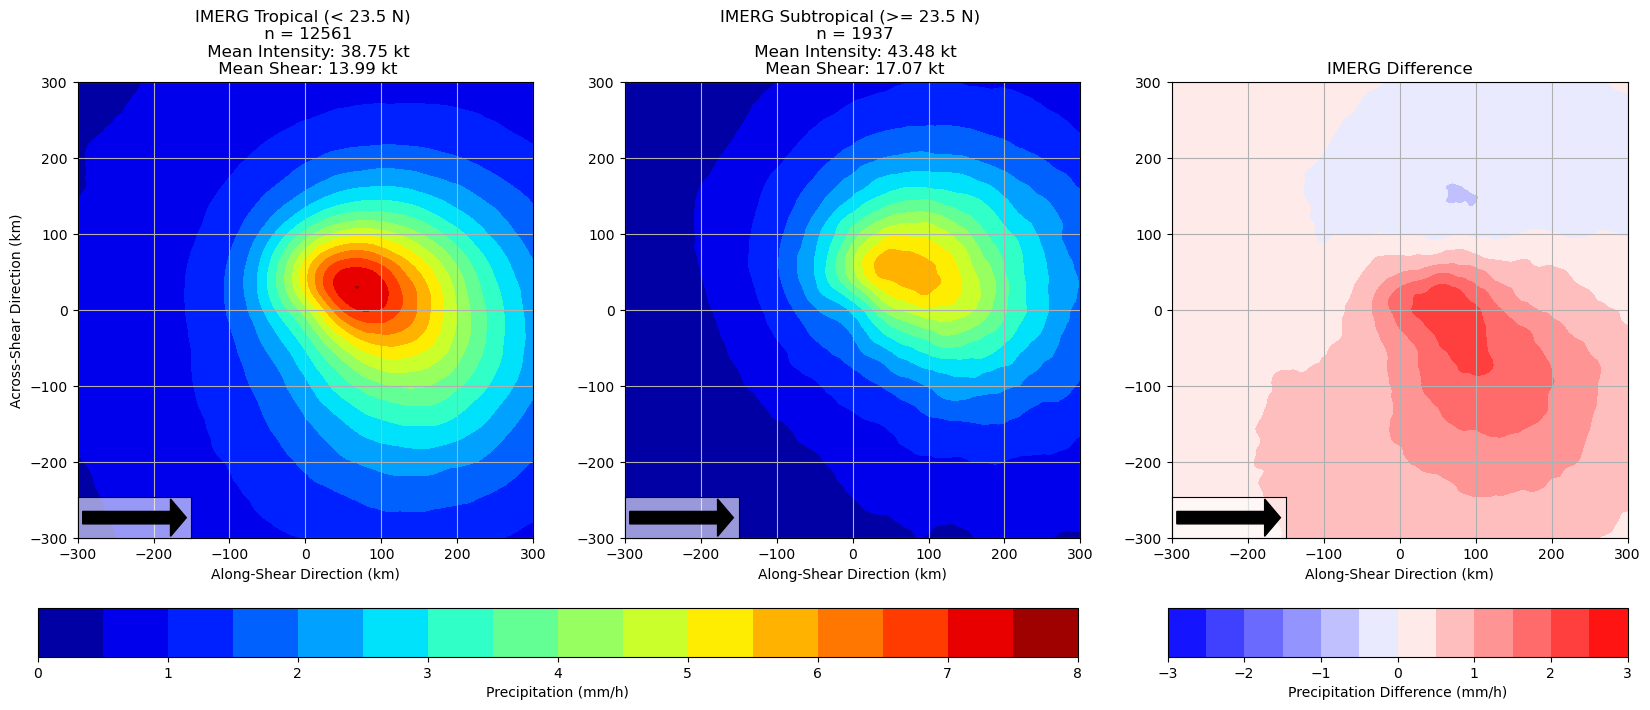

In [18]:
# Latitude Indices
lat_thresh = 23.5
subtropical_lat_cases = filtered_with_boo.where(filtered_with_boo['LAT'] >=lat_thresh).dropna().index

tropical_lat_cases = filtered_with_boo.where(filtered_with_boo['LAT'] <lat_thresh).dropna().index


weak_storm_and_subtropical_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,subtropical_lat_cases]))
weak_storm_and_tropical_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,tropical_lat_cases]))

subtropical_mean_intensity = filtered_with_boo.loc[weak_storm_and_subtropical_imerg['case']]['VMAX'].mean().round(2)
tropical_mean_intensity = filtered_with_boo.loc[weak_storm_and_tropical_imerg['case']]['VMAX'].mean().round(2)

subtropical_mean_shear = filtered_with_boo.loc[weak_storm_and_subtropical_imerg['case']]['SHRD'].mean().round(2)
tropical_mean_shear = filtered_with_boo.loc[weak_storm_and_tropical_imerg['case']]['SHRD'].mean().round(2)

fig = plt.figure(figsize=(20, 7)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)

small_shear_cf = ax.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_and_tropical_imerg.mean('case'),
                              levels=np.arange(0,8.1,0.5),cmap='jet')
ax.grid()
ax.set_title('IMERG Tropical (< '+str(lat_thresh)+' N) \n n = ' + str(
    len(weak_storm_and_tropical_imerg)) + '\n Mean Intensity: ' + str(tropical_mean_intensity) + 
             ' kt'+ '\n Mean Shear: ' + str(tropical_mean_shear) + ' kt')
ax.set_xlabel('Along-Shear Direction (km)')
ax.set_ylabel('Across-Shear Direction (km)')

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

moderate_shear_cf = ax2.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_and_subtropical_imerg.mean('case'),
                              levels=np.arange(0,8.1,0.5),cmap='jet')
ax2.grid()
ax2.set_title('IMERG Subtropical (>= '+str(lat_thresh)+' N) \n n = ' + str(
    len(weak_storm_and_subtropical_imerg)) + '\n Mean Intensity: ' + str(subtropical_mean_intensity) + ' kt'
             + '\n Mean Shear: ' + str(subtropical_mean_shear) + ' kt')
ax2.set_xlabel('Along-Shear Direction (km)')

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

diff_cf = ax3.contourf(imerg_cases['x'], imerg_cases['y'],
                               weak_storm_and_tropical_imerg.mean('case')- weak_storm_and_subtropical_imerg.mean('case'),
                              levels=np.arange(-3,3.1,0.5),cmap='bwr')
ax3.grid()
ax3.set_title('IMERG Difference')
ax3.set_xlabel('Along-Shear Direction (km)')

axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

cax_1 = plt.axes([0.105, 0, 0.52, 0.07])
cax_2 = plt.axes([0.67, 0, 0.23, 0.07])

# MAKE SURE COLOR LEVELS OF ALL PLOTS ARE SET EQUALLY!!!
plt.colorbar(moderate_shear_cf,cax=cax_1,label='Precipitation (mm/h)',orientation='horizontal')
plt.colorbar(diff_cf,cax=cax_2,label='Precipitation Difference (mm/h)',orientation='horizontal')

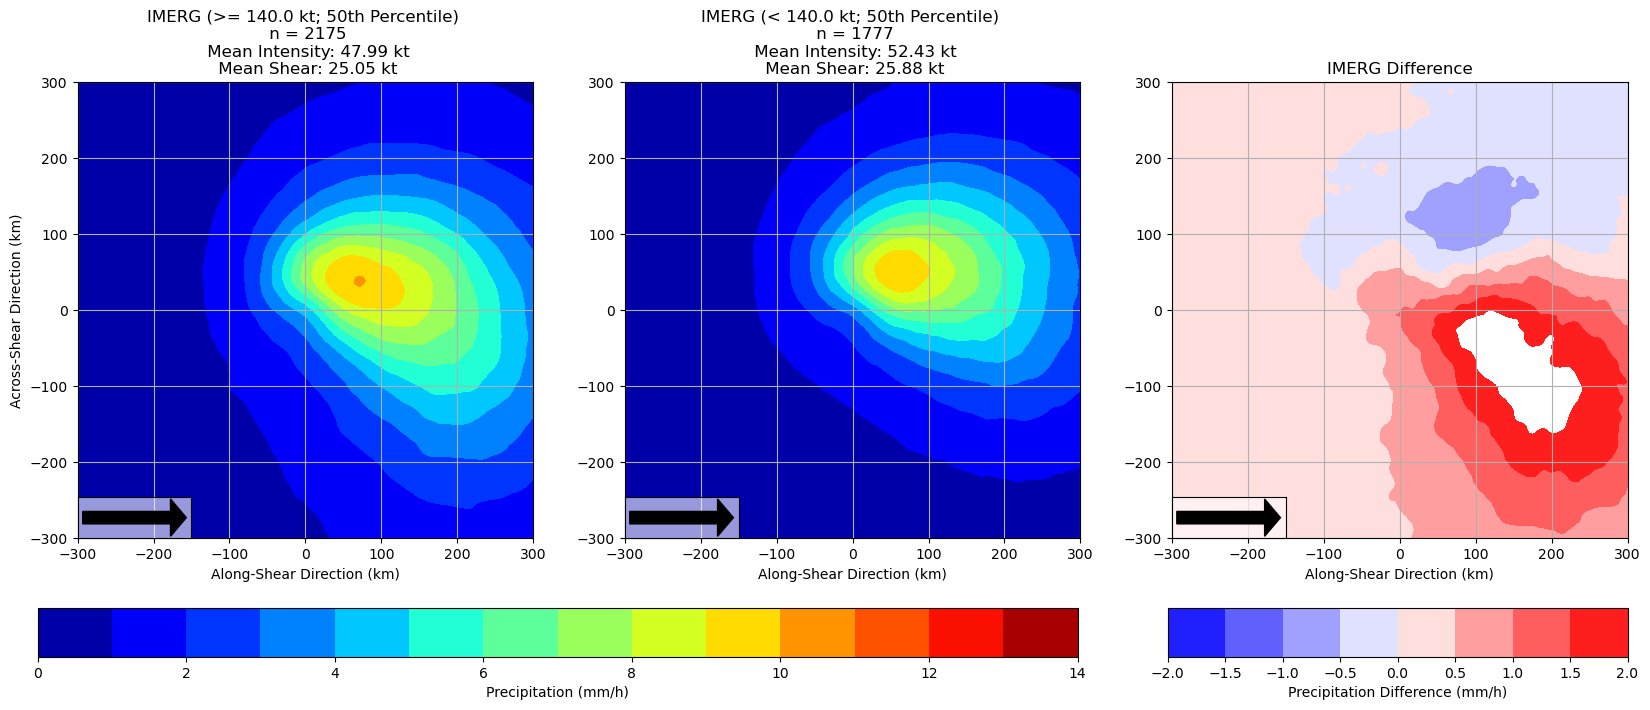

In [19]:
percentile_desired = 50
VMPI_percent = np.percentile(filtered_with_boo['VMPI'],percentile_desired)
VMPI_below_percent_thesh = filtered_with_boo.where(filtered_with_boo['VMPI'] < VMPI_percent).dropna().index
VMPI_above_percent_thesh = filtered_with_boo.where(filtered_with_boo['VMPI'] >= VMPI_percent).dropna().index

below_percent_VMPI_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([VMPI_below_percent_thesh,strong_shear_indices]))
above_percent_VMPI_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([VMPI_above_percent_thesh,strong_shear_indices]))

VMPI_above_mean_intensity = filtered_with_boo.loc[above_percent_VMPI_imerg['case']]['VMAX'].mean().round(2)
VMPI_below_mean_intensity = filtered_with_boo.loc[below_percent_VMPI_imerg['case']]['VMAX'].mean().round(2)

VMPI_above_mean_shear = filtered_with_boo.loc[above_percent_VMPI_imerg['case']]['SHRD'].mean().round(2)
VMPI_below_mean_shear = filtered_with_boo.loc[below_percent_VMPI_imerg['case']]['SHRD'].mean().round(2)


fig = plt.figure(figsize=(20, 7)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)

small_shear_cf = ax.contourf(imerg_cases['x'], imerg_cases['y'],above_percent_VMPI_imerg.mean('case'),
                              levels=np.arange(0,14.1,1),cmap='jet')
ax.grid()
ax.set_title('IMERG (>= '+str(VMPI_percent)+' kt; ' +str(percentile_desired) +'th Percentile) \n n = ' + str(
    len(above_percent_VMPI_imerg)) + '\n Mean Intensity: ' + str(VMPI_above_mean_intensity) + 
             ' kt'+ '\n Mean Shear: ' + str(VMPI_above_mean_shear) + ' kt')
ax.set_xlabel('Along-Shear Direction (km)')
ax.set_ylabel('Across-Shear Direction (km)')

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

moderate_shear_cf = ax2.contourf(imerg_cases['x'], imerg_cases['y'],below_percent_VMPI_imerg.mean('case'),
                              levels=np.arange(0,14.1,1),cmap='jet')
ax2.grid()
ax2.set_title('IMERG (< '+str(VMPI_percent)+' kt; ' +str(percentile_desired) +'th Percentile) \n n = ' + str(
    len(below_percent_VMPI_imerg)) + '\n Mean Intensity: ' + str(VMPI_below_mean_intensity) + ' kt'
             + '\n Mean Shear: ' + str(VMPI_below_mean_shear) + ' kt')
ax2.set_xlabel('Along-Shear Direction (km)')

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

diff_cf = ax3.contourf(imerg_cases['x'], imerg_cases['y'],
                               above_percent_VMPI_imerg.mean('case')- below_percent_VMPI_imerg.mean('case'),
                              levels=np.arange(-2,2.1,0.5),cmap='bwr')
ax3.grid()
ax3.set_title('IMERG Difference')
ax3.set_xlabel('Along-Shear Direction (km)')

axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

cax_1 = plt.axes([0.105, 0, 0.52, 0.07])
cax_2 = plt.axes([0.67, 0, 0.23, 0.07])

# MAKE SURE COLOR LEVELS OF ALL PLOTS ARE SET EQUALLY!!!
plt.colorbar(moderate_shear_cf,cax=cax_1,label='Precipitation (mm/h)',orientation='horizontal')
plt.colorbar(diff_cf,cax=cax_2,label='Precipitation Difference (mm/h)',orientation='horizontal')

In [20]:
# current_env_info = pd.DataFrame(filtered_with_boo_multi_index.loc[multiple_conditions_index_finder([weak_storm_indices,
#                                                        strong_shear_indices])].mean().round(2)).transpose()

# current_env_info.index = ['Strong Shear']

# current_env_info

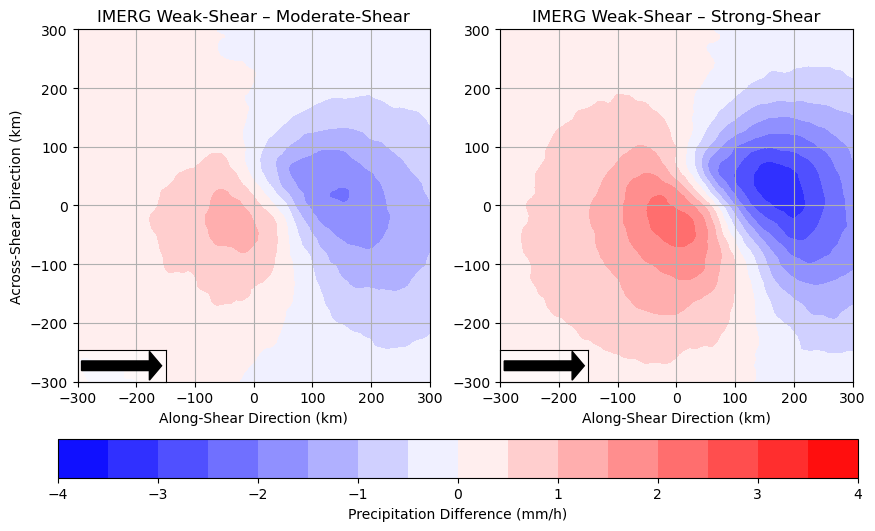

In [21]:
fig = plt.figure(figsize=(10, 5.5)) 

gs = fig.add_gridspec(1,2)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)

small_moderate_shear_diff_cf = ax.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_and_weak_shear_imerg.mean('case')-
                                           weak_storm_and_moderate_shear_imerg.mean('case'),
                              levels=np.arange(-4,4.1,0.5),cmap='bwr')
ax.grid()
ax.set_title('IMERG Weak-Shear – Moderate-Shear')
ax.set_xlabel('Along-Shear Direction (km)')
ax.set_ylabel('Across-Shear Direction (km)')

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

moderate_shear_cf = ax2.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_and_weak_shear_imerg.mean('case')-
                                 weak_storm_and_strong_shear_imerg.mean('case'),
                              levels=np.arange(-4,4.1,0.5),cmap='bwr')
ax2.grid()
ax2.set_title('IMERG Weak-Shear – Strong-Shear')
ax2.set_xlabel('Along-Shear Direction (km)')

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

cax = plt.axes([0.105, 0, 0.8, 0.07])
# MAKE SURE ALL COLOR LEVELS ARE SET EQUALLY!!!
plt.colorbar(moderate_shear_cf,cax=cax,label='Precipitation Difference (mm/h)',orientation='horizontal')
plt.savefig('/Users/acheung/data/Figures/Paper_Figures/IMERG_Shear_Diff.png',dpi=900,bbox_inches='tight')

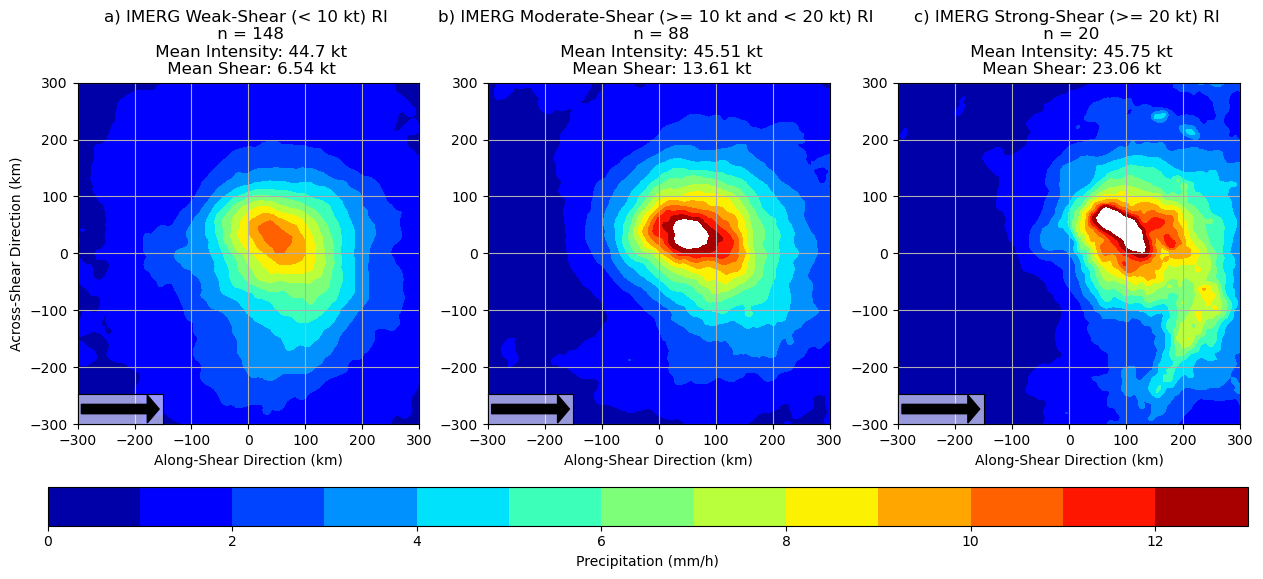

In [22]:
#---------------------------------------------------------Intensity Constrainer (if desired)---------------------------------------------------
desired_intensity_indices = filtered_cases.where((filtered_cases['VMAX'] <= 50) & (filtered_cases['VMAX'] >= 40)).dropna().index
#----------------------------------------------------------------------------------------------------------------------------------------------

    

weak_storm_weak_shear_RI_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,weak_shear_indices,RI_indices,desired_intensity_indices]))
weak_storm_moderate_shear_RI_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,moderate_shear_indices,
                                                                                            RI_indices,desired_intensity_indices]))
weak_storm_strong_shear_RI_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,strong_shear_indices,
                                                                                            RI_indices,desired_intensity_indices]))
weak_storm_weak_shear_RI_mean_intensity = filtered_with_boo.loc[weak_storm_weak_shear_RI_imerg['case']]['VMAX'].mean().round(2)
weak_storm_moderate_shear_RI_mean_intensity = filtered_with_boo.loc[weak_storm_moderate_shear_RI_imerg['case']]['VMAX'].mean().round(2)
weak_storm_strong_shear_RI_mean_intensity = filtered_with_boo.loc[weak_storm_strong_shear_RI_imerg['case']]['VMAX'].mean().round(2)

weak_storm_weak_shear_RI_mean_shear = filtered_with_boo.loc[weak_storm_weak_shear_RI_imerg['case']]['SHRD'].mean().round(2)
weak_storm_moderate_shear_RI_mean_shear = filtered_with_boo.loc[weak_storm_moderate_shear_RI_imerg['case']]['SHRD'].mean().round(2)
weak_storm_strong_shear_RI_mean_shear = filtered_with_boo.loc[weak_storm_strong_shear_RI_imerg['case']]['SHRD'].mean().round(2)


fig = plt.figure(figsize=(15, 5.5)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)


weak_storm_weak_shear_RI_cf = ax.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_weak_shear_RI_imerg.mean('case'),
                              levels=np.arange(0,13.1,1),cmap='jet')
ax.grid()
ax.set_title('a) IMERG Weak-Shear (< 10 kt) RI \n n = ' + str(len(weak_storm_weak_shear_RI_imerg))
             + '\n Mean Intensity: ' + str(weak_storm_weak_shear_RI_mean_intensity) + ' kt'
             + '\n Mean Shear: ' + str(weak_storm_weak_shear_RI_mean_shear) + ' kt')
ax.set_xlabel('Along-Shear Direction (km)')
ax.set_ylabel('Across-Shear Direction (km)')

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

weak_storm_moderate_shear_RI_cf = ax2.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_moderate_shear_RI_imerg.mean('case'),
                              levels=np.arange(0,13.1,1),cmap='jet')
ax2.grid()
ax2.set_title('b) IMERG Moderate-Shear (>= 10 kt and < 20 kt) RI \n n = ' + str(len(weak_storm_moderate_shear_RI_imerg))
             + '\n Mean Intensity: ' + str(weak_storm_moderate_shear_RI_mean_intensity) + ' kt'
             + '\n Mean Shear: ' + str(weak_storm_moderate_shear_RI_mean_shear) + ' kt')
ax2.set_xlabel('Along-Shear Direction (km)')

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

weak_storm_strong_shear_RI_cf = ax3.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_strong_shear_RI_imerg.mean('case'),
                              levels=np.arange(0,13.1,1),cmap='jet')
ax3.grid()
ax3.set_title('c) IMERG Strong-Shear (>= 20 kt) RI \n n = ' + str(len(weak_storm_strong_shear_RI_imerg))
             + '\n Mean Intensity: ' + str(weak_storm_strong_shear_RI_mean_intensity) + ' kt'
             + '\n Mean Shear: ' + str(weak_storm_strong_shear_RI_mean_shear) + ' kt')
ax3.set_xlabel('Along-Shear Direction (km)')

axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

cax = plt.axes([0.105, 0, 0.8, 0.07])
# MAKE SURE COLOR LEVELS OF ALL PLOTS ARE SET EQUALLY!!!
plt.colorbar(weak_storm_strong_shear_RI_cf,cax=cax,label='Precipitation (mm/h)',orientation='horizontal')
plt.savefig('/Users/acheung/data/Figures/Paper_Figures/weak_storm_RI_weak_shear.png', dpi=900,bbox_inches='tight')

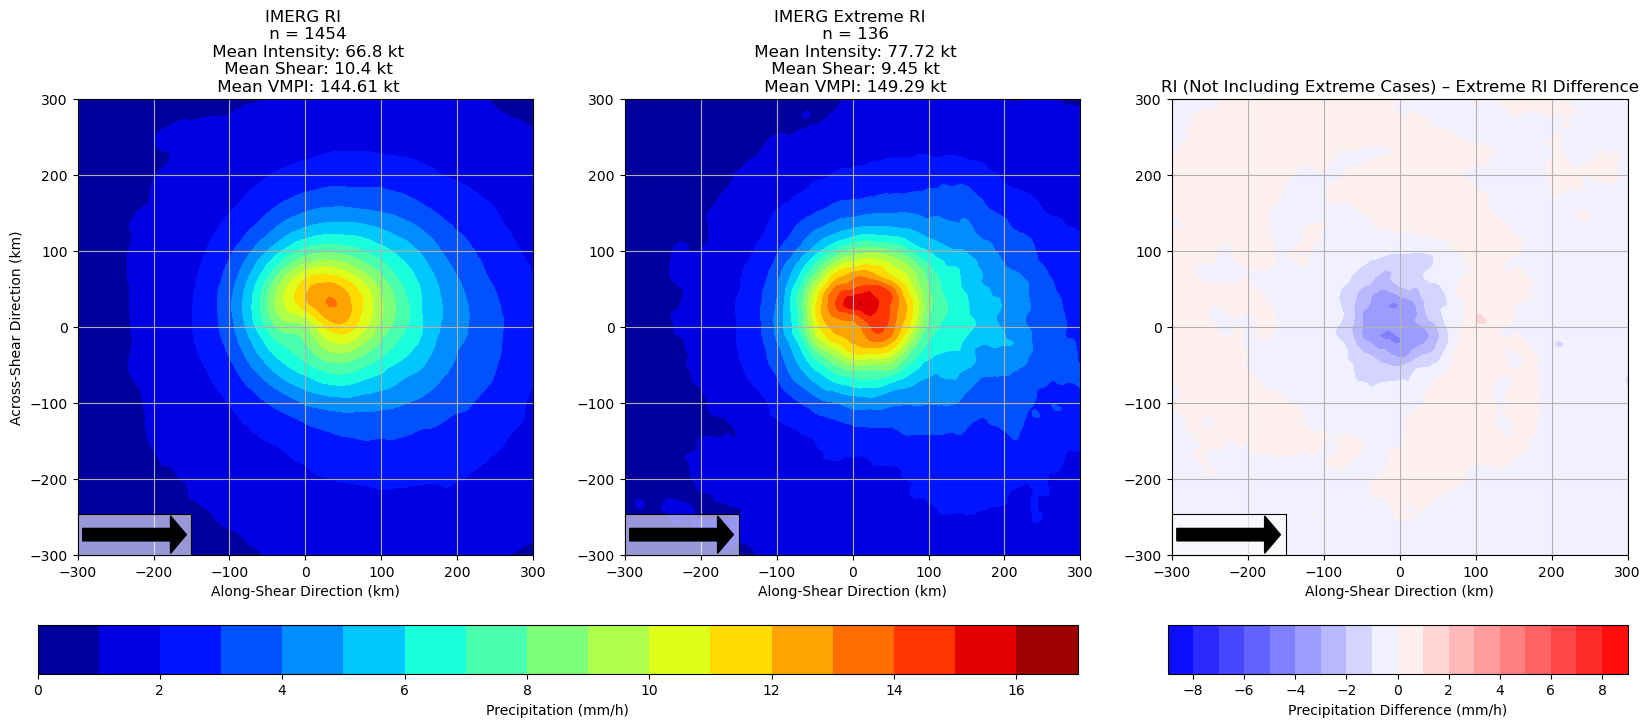

In [23]:
fig = plt.figure(figsize=(20, 7)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)

RI_imerg_data = imerg_cases.sel(case=multiple_conditions_index_finder([RI_indices,Non_Extreme_RI_indices]))
RI_mean_intensity = filtered_with_boo.loc[RI_imerg_data['case']]['VMAX'].mean().round(2)
RI_mean_shear = filtered_with_boo.loc[RI_imerg_data['case']]['SHRD'].mean().round(2)
RI_mean_VMPI = filtered_with_boo.loc[RI_imerg_data['case']]['VMPI'].mean().round(2)

Extreme_RI_imerg_data = imerg_cases.sel(case=multiple_conditions_index_finder([Extreme_RI_indices]))
Extreme_RI_mean_intensity = filtered_with_boo.loc[Extreme_RI_imerg_data['case']]['VMAX'].mean().round(2)
Extreme_RI_mean_shear = filtered_with_boo.loc[Extreme_RI_imerg_data['case']]['SHRD'].mean().round(2)
Extreme_RI_mean_VMPI = filtered_with_boo.loc[Extreme_RI_imerg_data['case']]['VMPI'].mean().round(2)

#------------------------------------------------------------------------------------------------------------------
extreme_RI_table = filtered_with_boo.loc[Extreme_RI_imerg_data['case']]
unique_extreme_ids = extreme_RI_table['Storm_ID'].unique()

curr_extreme_storm_first_list = []
for first_ids in unique_extreme_ids:
    curr_extreme_storm = extreme_RI_table.where(extreme_RI_table['Storm_ID']==first_ids).dropna()
    curr_extreme_storm_first = curr_extreme_storm.iloc[0]
    curr_extreme_storm_first_list.append(curr_extreme_storm_first)
    
extreme_first_pd = pd.DataFrame(curr_extreme_storm_first_list)
Extreme_RI_first_imerg_data = imerg_cases.sel(case=extreme_first_pd.index)

#------------------------------------------------------------------------------------------------------------------

RI_table = filtered_with_boo.loc[RI_imerg_data['case']]
unique_RI_ids = RI_table['Storm_ID'].unique()

curr_RI_storm_first_list = []
for first_RI_ids in unique_RI_ids:
    curr_RI_storm = RI_table.where(RI_table['Storm_ID']==first_RI_ids).dropna()
    curr_RI_storm_first = curr_RI_storm.iloc[0]
    curr_RI_storm_first_list.append(curr_RI_storm_first)
    
RI_first_pd = pd.DataFrame(curr_RI_storm_first_list)
RI_first_imerg_data = imerg_cases.sel(case=RI_first_pd.index)

#------------------------------------------------------------------------------------------------------------------

first_or_not = False

if first_or_not == True:
    
    RI_plot = ax.contourf(imerg_cases['x'], imerg_cases['y'],RI_first_imerg_data.mean('case'),cmap='jet',levels=np.arange(0,17.1,1))
    ax.grid()
    ax.set_title('IMERG RI \n n = ' + str(len(RI_first_imerg_data))
                 + '\n Mean Intensity: ' + str(RI_first_pd['VMAX'].mean().round(2)) + ' kt'
                 + '\n Mean Shear: ' + str(RI_first_pd['SHRD'].mean().round(2)) + ' kt'
                + '\n Mean VMPI: ' + str(RI_first_pd['VMPI'].mean().round(2)) + ' kt')
    ax.set_xlabel('Along-Shear Direction (km)')
    ax.set_ylabel('Across-Shear Direction (km)')

    axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
    axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins.patch.set_alpha(0.6)
    q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

    Extreme_RI_plot = ax2.contourf(imerg_cases['x'], imerg_cases['y'],Extreme_RI_first_imerg_data.mean('case'),
                                  levels=np.arange(0,17.1,1),cmap='jet')
    ax2.grid()
    ax2.set_title('IMERG Extreme RI \n n = ' + str(len(Extreme_RI_first_imerg_data))
                 + '\n Mean Intensity: ' + str(extreme_first_pd['VMAX'].mean().round(2)) + ' kt'
                 + '\n Mean Shear: ' + str(extreme_first_pd['SHRD'].mean().round(2)) + ' kt'
                 + '\n Mean VMPI: ' + str(extreme_first_pd['VMPI'].mean().round(2)) + ' kt')
    ax2.set_xlabel('Along-Shear Direction (km)')

    axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
    axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins2.patch.set_alpha(0.6)
    q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

    Extreme_RI_RI_diff_plot = ax3.contourf(imerg_cases['x'], imerg_cases['y'],
                                           RI_first_imerg_data.mean('case')-Extreme_RI_first_imerg_data.mean('case'),
                                           levels=np.arange(-9,9.1,1),cmap='bwr')
    ax3.grid()
    ax3.set_title('RI (Not Including Extreme Cases) – Extreme RI Difference')
    ax3.set_xlabel('Along-Shear Direction (km)')

    axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
    axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins3.patch.set_alpha(0.6)
    q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

    cax_1 = plt.axes([0.105, 0, 0.52, 0.07])
    cax_2 = plt.axes([0.67, 0, 0.23, 0.07])

    # MAKE SURE COLOR LEVELS OF ALL PLOTS ARE SET EQUALLY!!!
    plt.colorbar(Extreme_RI_plot,cax=cax_1,label='Precipitation (mm/h)',orientation='horizontal')
    plt.colorbar(Extreme_RI_RI_diff_plot,cax=cax_2,label='Precipitation Difference (mm/h)',orientation='horizontal')

elif first_or_not == False:

    RI_plot = ax.contourf(imerg_cases['x'], imerg_cases['y'],RI_imerg_data.mean('case'),cmap='jet',levels=np.arange(0,17.1,1))
    ax.grid()
    ax.set_title('IMERG RI \n n = ' + str(len(RI_imerg_data))
                 + '\n Mean Intensity: ' + str(RI_mean_intensity) + ' kt'
                 + '\n Mean Shear: ' + str(RI_mean_shear) + ' kt'
                 '\n Mean VMPI: ' + str(RI_mean_VMPI) + ' kt')
    ax.set_xlabel('Along-Shear Direction (km)')
    ax.set_ylabel('Across-Shear Direction (km)')

    axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
    axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins.patch.set_alpha(0.6)
    q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

    Extreme_RI_plot = ax2.contourf(imerg_cases['x'], imerg_cases['y'],Extreme_RI_imerg_data.mean('case'),
                                  levels=np.arange(0,17.1,1),cmap='jet')
    ax2.grid()
    ax2.set_title('IMERG Extreme RI \n n = ' + str(len(Extreme_RI_imerg_data))
                 + '\n Mean Intensity: ' + str(Extreme_RI_mean_intensity) + ' kt'
                 + '\n Mean Shear: ' + str(Extreme_RI_mean_shear) + ' kt'
                 + '\n Mean VMPI: ' + str(Extreme_RI_mean_VMPI) + ' kt')
    ax2.set_xlabel('Along-Shear Direction (km)')

    axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
    axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins2.patch.set_alpha(0.6)
    q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

    Extreme_RI_RI_diff_plot = ax3.contourf(imerg_cases['x'], imerg_cases['y'],
                                           RI_imerg_data.mean('case')-Extreme_RI_imerg_data.mean('case'),
                                           levels=np.arange(-9,9.1,1),cmap='bwr')
    ax3.grid()
    ax3.set_title('RI (Not Including Extreme Cases) – Extreme RI Difference')
    ax3.set_xlabel('Along-Shear Direction (km)')

    axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
    axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins3.patch.set_alpha(0.6)
    q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

    cax_1 = plt.axes([0.105, 0, 0.52, 0.07])
    cax_2 = plt.axes([0.67, 0, 0.23, 0.07])

    # MAKE SURE COLOR LEVELS OF ALL PLOTS ARE SET EQUALLY!!!
    plt.colorbar(Extreme_RI_plot,cax=cax_1,label='Precipitation (mm/h)',orientation='horizontal')
    plt.colorbar(Extreme_RI_RI_diff_plot,cax=cax_2,label='Precipitation Difference (mm/h)',orientation='horizontal')

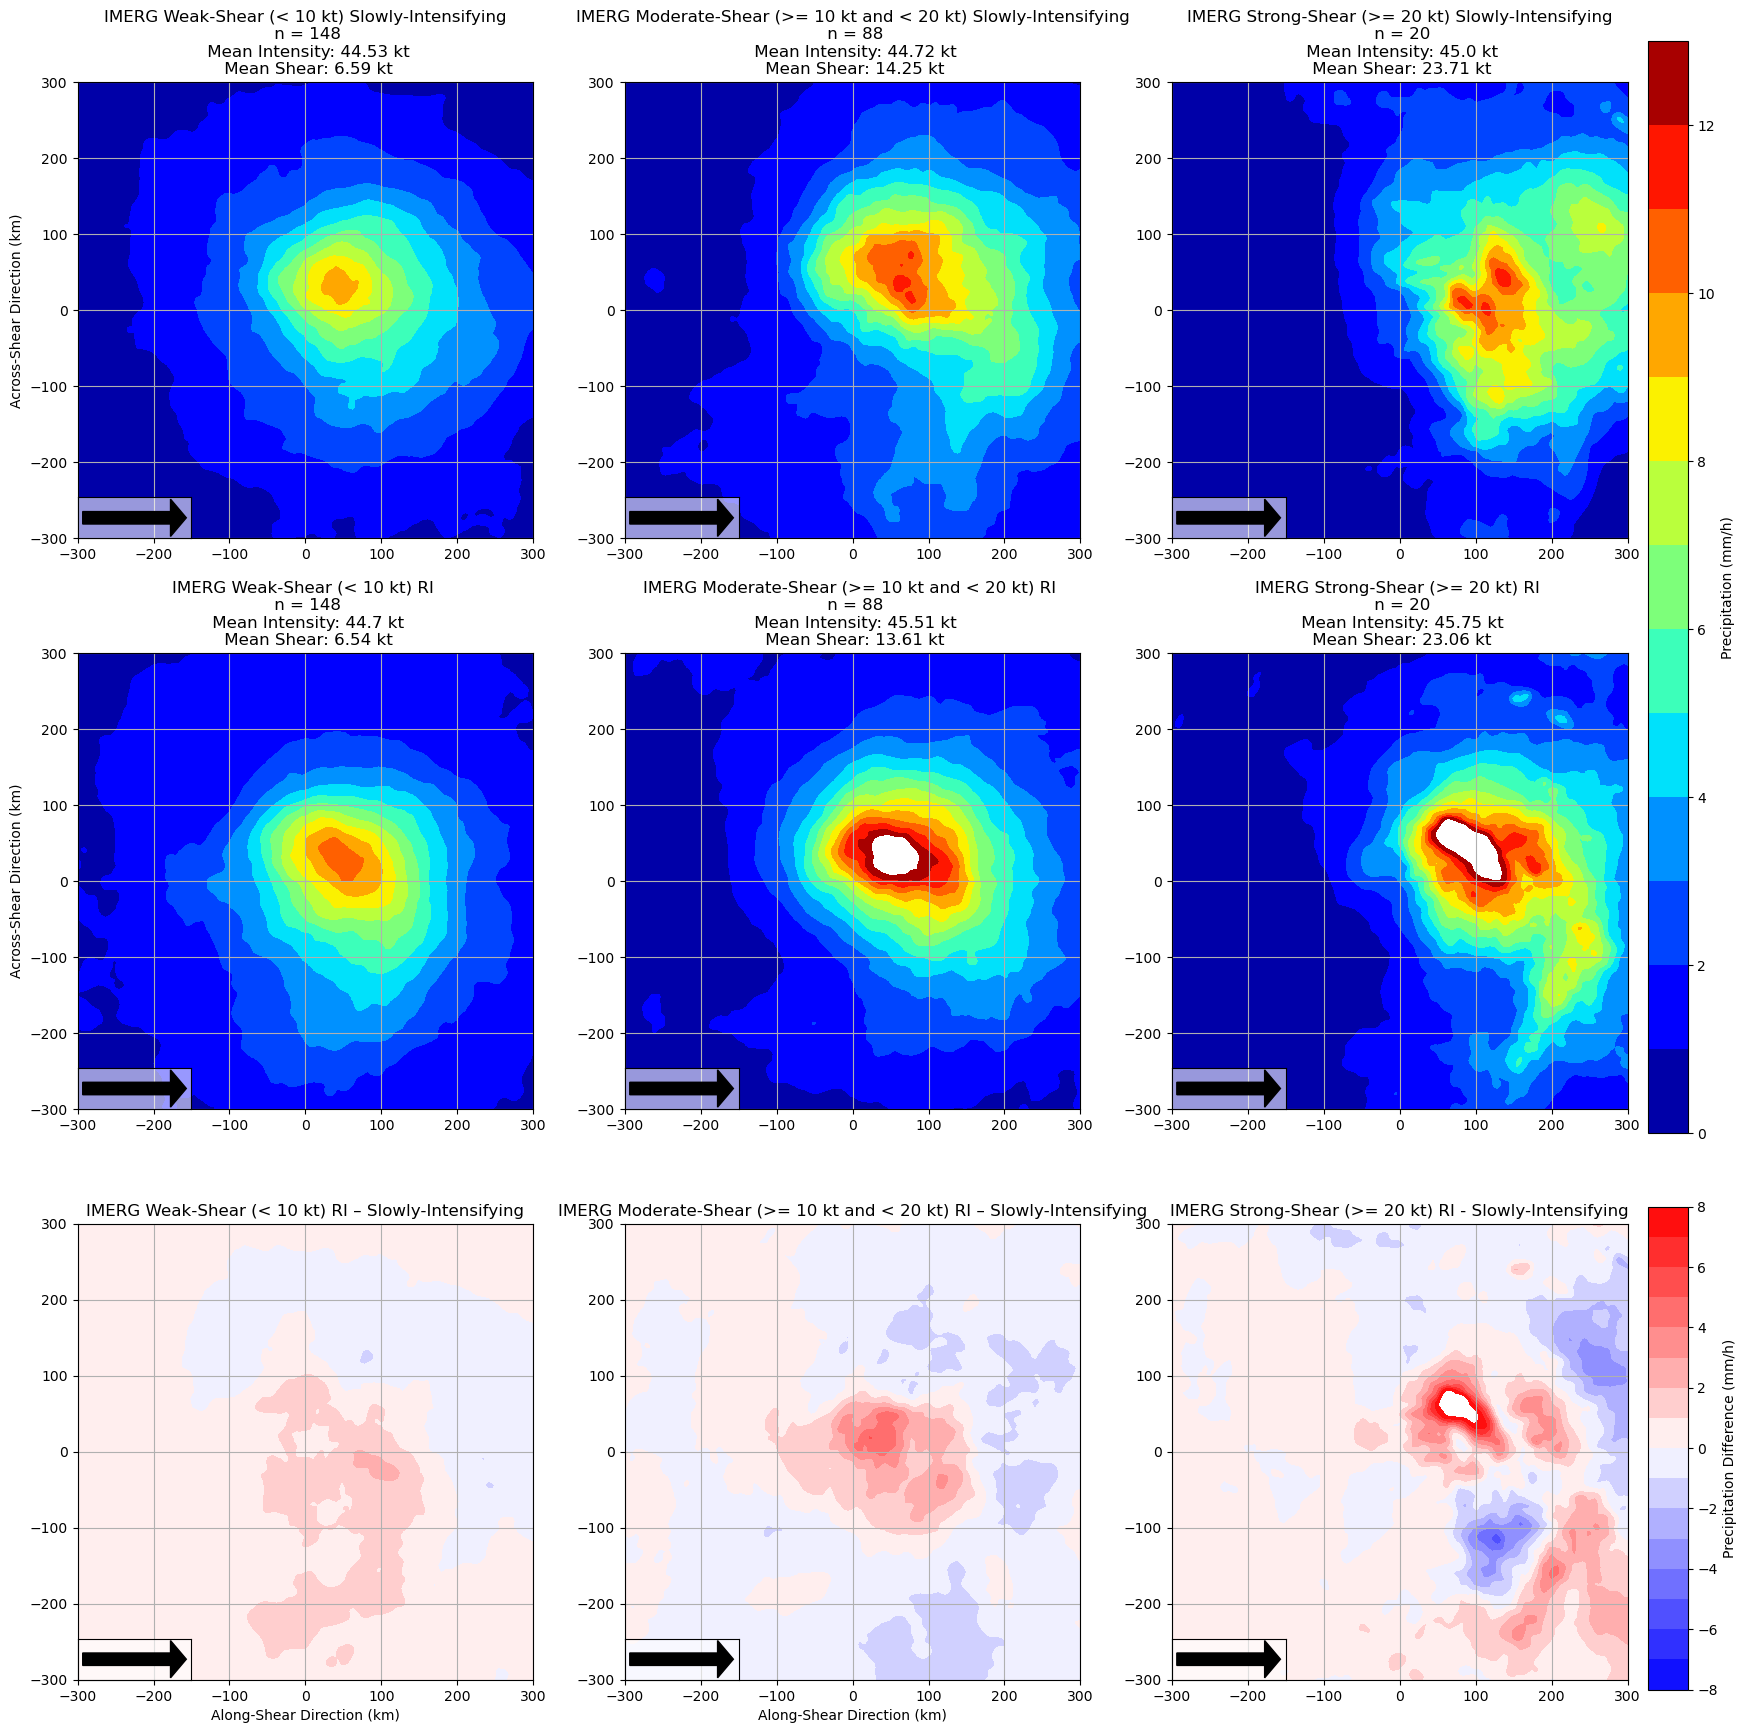

In [24]:
fig = plt.figure(figsize=(20, 21)) 

gs = fig.add_gridspec(3,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)
ax4 = fig.add_subplot(gs[1, 0],adjustable='box', aspect=1)
ax5 = fig.add_subplot(gs[1, 1],adjustable='box', aspect=1)
ax6 = fig.add_subplot(gs[1, 2],adjustable='box', aspect=1)
ax7 = fig.add_subplot(gs[2, 0],adjustable='box', aspect=1)
ax8 = fig.add_subplot(gs[2, 1],adjustable='box', aspect=1)
ax9 = fig.add_subplot(gs[2, 2],adjustable='box', aspect=1)

comparison_mode = 'Slowly-Intensifying'

if comparison_mode == 'Slowly-Intensifying':
    Mode_indices = Slowly_intensifying_indices
elif comparison_mode == 'Steady-State':
    Mode_indices = SS_indices
elif comparison_mode == 'Weakening':
    Mode_indices = Weakening_indices
elif comparison_mode == 'Non-RI':
    Mode_indices = Non_RI_indices
    
    
weak_storm_weak_shear_mode_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,weak_shear_indices,
                                                                                            Mode_indices,desired_intensity_indices]))

weak_storm_moderate_shear_mode_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,moderate_shear_indices,
                                                                                            Mode_indices,desired_intensity_indices]))

weak_storm_strong_shear_mode_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,strong_shear_indices,
                                                                                            Mode_indices,desired_intensity_indices]))

weak_storm_weak_shear_RI_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,weak_shear_indices,RI_indices,desired_intensity_indices]))
weak_storm_moderate_shear_RI_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,moderate_shear_indices,
                                                                                            RI_indices,desired_intensity_indices]))
weak_storm_strong_shear_RI_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,strong_shear_indices,
                                                                                            RI_indices,desired_intensity_indices]))


sample_picker = True
if sample_picker == True:
    weak_storm_weak_shear_mode_imerg = weak_storm_weak_shear_mode_imerg.sel(case = np.random.choice(weak_storm_weak_shear_mode_imerg["case"], size=len(weak_storm_weak_shear_RI_imerg), replace=False))
    weak_storm_moderate_shear_mode_imerg = weak_storm_moderate_shear_mode_imerg.sel(case = np.random.choice(weak_storm_moderate_shear_mode_imerg["case"], size=len(weak_storm_moderate_shear_RI_imerg), replace=False))
    weak_storm_strong_shear_mode_imerg = weak_storm_strong_shear_mode_imerg.sel(case = np.random.choice(weak_storm_strong_shear_mode_imerg["case"], size=len(weak_storm_strong_shear_RI_imerg), replace=False))
    
weak_storm_weak_shear_mode_mean_intensity = filtered_with_boo.loc[weak_storm_weak_shear_mode_imerg['case']]['VMAX'].mean().round(2)
weak_storm_moderate_shear_mode_mean_intensity = filtered_with_boo.loc[weak_storm_moderate_shear_mode_imerg['case']]['VMAX'].mean().round(2)
weak_storm_strong_shear_mode_mean_intensity = filtered_with_boo.loc[weak_storm_strong_shear_mode_imerg['case']]['VMAX'].mean().round(2)

weak_storm_weak_shear_mode_mean_shear = filtered_with_boo.loc[weak_storm_weak_shear_mode_imerg['case']]['SHRD'].mean().round(2)
weak_storm_moderate_shear_mode_mean_shear = filtered_with_boo.loc[weak_storm_moderate_shear_mode_imerg['case']]['SHRD'].mean().round(2)
weak_storm_strong_shear_mode_mean_shear = filtered_with_boo.loc[weak_storm_strong_shear_mode_imerg['case']]['SHRD'].mean().round(2)


weak_storm_weak_shear_mode_cf = ax.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_weak_shear_mode_imerg.mean('case'),
                              levels=np.arange(0,13.1,1),cmap='jet')

ax.grid()
ax.set_title('IMERG Weak-Shear (< 10 kt) ' + comparison_mode +'\n n = ' + str(len(weak_storm_weak_shear_mode_imerg))+
             '\n Mean Intensity: ' + str(weak_storm_weak_shear_mode_mean_intensity) + ' kt'
             + '\n Mean Shear: ' + str(weak_storm_weak_shear_mode_mean_shear) + ' kt')
ax.set_ylabel('Across-Shear Direction (km)')

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

weak_storm_moderate_shear_mode_cf = ax2.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_moderate_shear_mode_imerg.mean('case'),
                              levels=np.arange(0,13.1,1),cmap='jet')
ax2.grid()
ax2.set_title('IMERG Moderate-Shear (>= 10 kt and < 20 kt) ' +comparison_mode + '\n n = ' + str(len(weak_storm_moderate_shear_mode_imerg))
             +
             '\n Mean Intensity: ' + str(weak_storm_moderate_shear_mode_mean_intensity) + ' kt'
             + '\n Mean Shear: ' + str(weak_storm_moderate_shear_mode_mean_shear) + ' kt')

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

weak_storm_strong_shear_mode_cf = ax3.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_strong_shear_mode_imerg.mean('case'),
                              levels=np.arange(0,13.1,1),cmap='jet')
ax3.grid()
ax3.set_title('IMERG Strong-Shear (>= 20 kt) '+comparison_mode+'\n n = ' + str(len(weak_storm_strong_shear_mode_imerg))
             +'\n Mean Intensity: ' + str(weak_storm_strong_shear_mode_mean_intensity) + ' kt'
             + '\n Mean Shear: ' + str(weak_storm_strong_shear_mode_mean_shear) + ' kt')

axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

weak_storm_weak_shear_RI_cf = ax4.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_weak_shear_RI_imerg.mean('case'),
                              levels=np.arange(0,13.1,1),cmap='jet')
ax4.grid()
ax4.set_title('IMERG Weak-Shear (< 10 kt) RI \n n = ' + str(len(weak_storm_weak_shear_RI_imerg))+
             '\n Mean Intensity: ' + str(weak_storm_weak_shear_RI_mean_intensity) + ' kt'
             + '\n Mean Shear: ' + str(weak_storm_weak_shear_RI_mean_shear) + ' kt')
ax4.set_ylabel('Across-Shear Direction (km)')

axins4 = inset_axes(ax4, width="25%", height="9%", loc=3, borderpad=0)
axins4.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins4.patch.set_alpha(0.6)
q4 = axins4.arrow(0,0,0.05,0,color='black',head_length = 0.009)

weak_storm_moderate_shear_RI_cf = ax5.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_moderate_shear_RI_imerg.mean('case'),
                              levels=np.arange(0,13.1,1),cmap='jet')
ax5.grid()
ax5.set_title('IMERG Moderate-Shear (>= 10 kt and < 20 kt) RI \n n = ' + str(len(weak_storm_moderate_shear_RI_imerg))+
             '\n Mean Intensity: ' + str(weak_storm_moderate_shear_RI_mean_intensity) + ' kt'
             + '\n Mean Shear: ' + str(weak_storm_moderate_shear_RI_mean_shear) + ' kt')

axins5 = inset_axes(ax5, width="25%", height="9%", loc=3, borderpad=0)
axins5.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins5.patch.set_alpha(0.6)
q5 = axins5.arrow(0,0,0.05,0,color='black',head_length = 0.009)

weak_storm_strong_shear_RI_cf = ax6.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_strong_shear_RI_imerg.mean('case'),
                              levels=np.arange(0,13.1,1),cmap='jet')
ax6.grid()
ax6.set_title('IMERG Strong-Shear (>= 20 kt) RI \n n = ' + str(len(weak_storm_strong_shear_RI_imerg))+
             '\n Mean Intensity: ' + str(weak_storm_strong_shear_RI_mean_intensity) + ' kt'
             + '\n Mean Shear: ' + str(weak_storm_strong_shear_RI_mean_shear) + ' kt')

axins6 = inset_axes(ax6, width="25%", height="9%", loc=3, borderpad=0)
axins6.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins6.patch.set_alpha(0.6)
q6 = axins6.arrow(0,0,0.05,0,color='black',head_length = 0.009)


weak_storm_weak_shear_diff_cf = ax7.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_weak_shear_RI_imerg.mean('case') - 
                                             weak_storm_weak_shear_mode_imerg.mean('case'),
                              levels=np.arange(-8,8.1,1),cmap='bwr')
ax7.grid()
ax7.set_title('IMERG Weak-Shear (< 10 kt) RI – ' + comparison_mode)
ax7.set_xlabel('Along-Shear Direction (km)')

axins7 = inset_axes(ax7, width="25%", height="9%", loc=3, borderpad=0)
axins7.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins7.patch.set_alpha(0.6)
q7 = axins7.arrow(0,0,0.05,0,color='black',head_length = 0.009)

weak_storm_moderate_shear_diff_cf = ax8.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_moderate_shear_RI_imerg.mean('case')-
                                                 weak_storm_moderate_shear_mode_imerg.mean('case'),
                              levels=np.arange(-8,8.1,1),cmap='bwr')
ax8.grid()
ax8.set_title('IMERG Moderate-Shear (>= 10 kt and < 20 kt) RI – ' + comparison_mode)
ax8.set_xlabel('Along-Shear Direction (km)')

axins8 = inset_axes(ax8, width="25%", height="9%", loc=3, borderpad=0)
axins8.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins8.patch.set_alpha(0.6)
q8 = axins8.arrow(0,0,0.05,0,color='black',head_length = 0.009)

weak_storm_strong_shear_diff_cf = ax9.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_strong_shear_RI_imerg.mean('case')-
                                               weak_storm_strong_shear_mode_imerg.mean('case'),
                              levels=np.arange(-8,8.1,1),cmap='bwr')
ax9.grid()
ax9.set_title('IMERG Strong-Shear (>= 20 kt) RI - ' + comparison_mode)

axins9 = inset_axes(ax9, width="25%", height="9%", loc=3, borderpad=0)
axins9.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins9.patch.set_alpha(0.6)
q9 = axins9.arrow(0,0,0.05,0,color='black',head_length = 0.009)

cax = plt.axes([0.91, 0.375, 0.02, 0.52])
plt.colorbar(weak_storm_strong_shear_mode_cf,label='Precipitation (mm/h)',cax=cax)

cax_diff = plt.axes([0.91, 0.11, 0.02, 0.23])
plt.colorbar(weak_storm_strong_shear_diff_cf,label='Precipitation Difference (mm/h)',cax=cax_diff)


/tmp/ipykernel_1606137/1692004883.py:171: UserWarning: Adding colorbar to a different Figure <Figure size 2000x2100 with 20 Axes> than <Figure size 1500x1100 with 13 Axes> which fig.colorbar is called on.
  plt.colorbar(weak_storm_strong_shear_mode_cf,label='Precipitation (mm/h)',cax=cax)


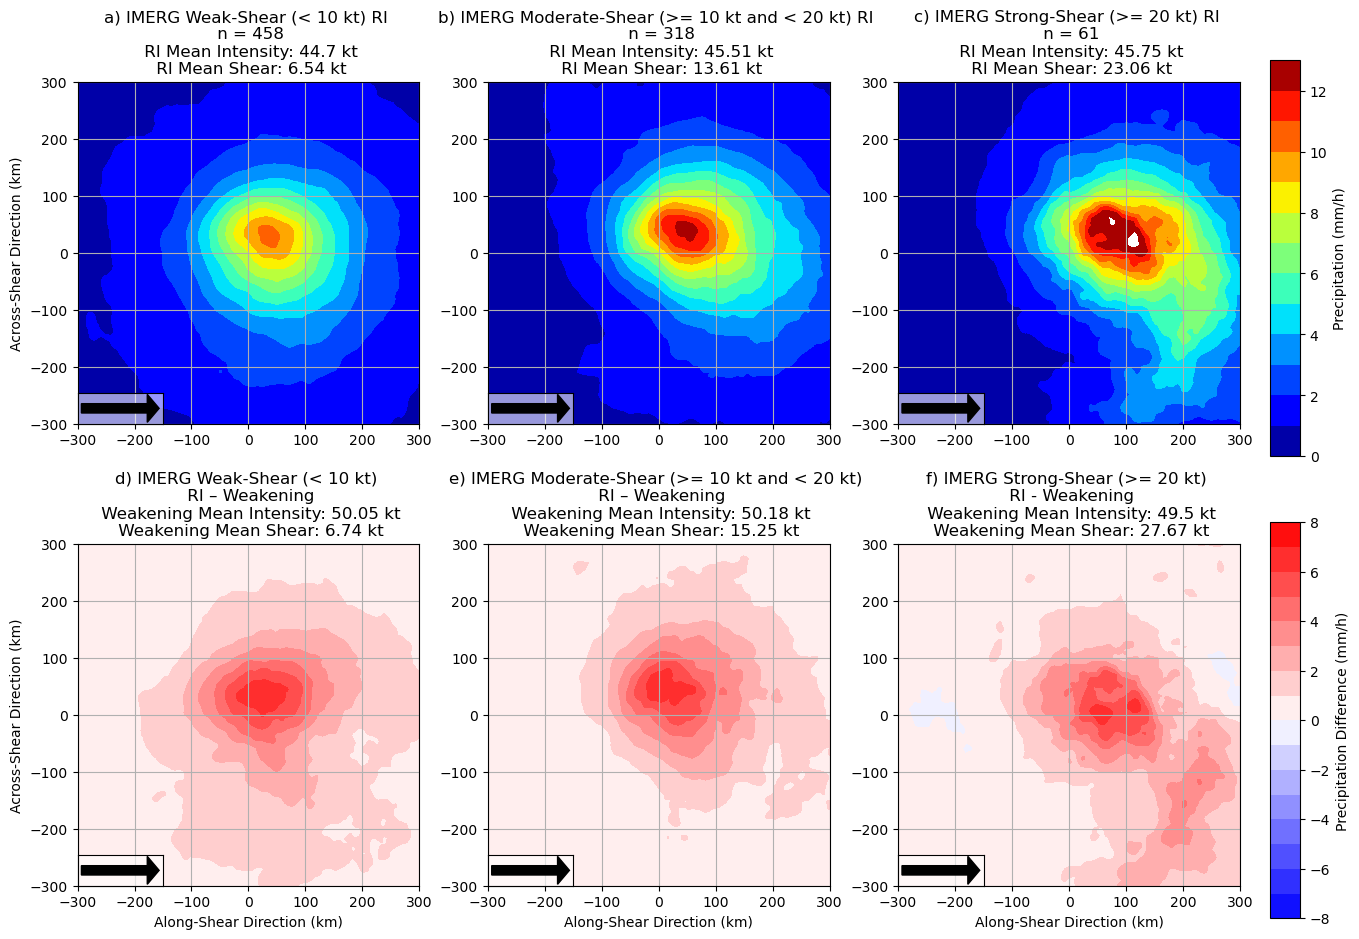

In [25]:
fig = plt.figure(figsize=(15, 11)) 

gs = fig.add_gridspec(2,3)
# ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
# ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
# ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)
ax4 = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax5 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax6 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)
ax7 = fig.add_subplot(gs[1, 0],adjustable='box', aspect=1)
ax8 = fig.add_subplot(gs[1, 1],adjustable='box', aspect=1)
ax9 = fig.add_subplot(gs[1, 2],adjustable='box', aspect=1)

comparison_mode = 'Weakening'

if comparison_mode == 'Slowly-Intensifying':
    Mode_indices = Slowly_intensifying_indices
elif comparison_mode == 'Steady-State':
    Mode_indices = SS_indices
elif comparison_mode == 'Weakening':
    Mode_indices = Weakening_indices
elif comparison_mode == 'Non-RI':
    Mode_indices = Non_RI_indices
    

weak_storm_weak_shear_mode_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,weak_shear_indices,
                                                                                            Mode_indices]))

weak_storm_moderate_shear_mode_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,moderate_shear_indices,
                                                                                            Mode_indices]))

weak_storm_strong_shear_mode_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,strong_shear_indices,
                                                                                            Mode_indices]))

weak_storm_weak_shear_RI_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,weak_shear_indices,RI_indices]))
weak_storm_moderate_shear_RI_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,moderate_shear_indices,
                                                                                            RI_indices]))
weak_storm_strong_shear_RI_imerg = imerg_cases.sel(case=multiple_conditions_index_finder([weak_storm_indices,strong_shear_indices,
                                                                                            RI_indices]))

weak_storm_weak_shear_mode_mean_intensity = filtered_with_boo.loc[weak_storm_weak_shear_mode_imerg['case']]['VMAX'].mean().round(2)
weak_storm_moderate_shear_mode_mean_intensity = filtered_with_boo.loc[weak_storm_moderate_shear_mode_imerg['case']]['VMAX'].mean().round(2)
weak_storm_strong_shear_mode_mean_intensity = filtered_with_boo.loc[weak_storm_strong_shear_mode_imerg['case']]['VMAX'].mean().round(2)

weak_storm_weak_shear_mode_mean_shear = filtered_with_boo.loc[weak_storm_weak_shear_mode_imerg['case']]['SHRD'].mean().round(2)
weak_storm_moderate_shear_mode_mean_shear = filtered_with_boo.loc[weak_storm_moderate_shear_mode_imerg['case']]['SHRD'].mean().round(2)
weak_storm_strong_shear_mode_mean_shear = filtered_with_boo.loc[weak_storm_strong_shear_mode_imerg['case']]['SHRD'].mean().round(2)


# weak_storm_weak_shear_mode_cf = ax.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_weak_shear_mode_imerg.mean('case'),
#                               levels=np.arange(0,13.1,1),cmap='jet')

# ax.grid()
# ax.set_title('IMERG Weak-Shear (< 10 kt) ' + comparison_mode +'\n n = ' + str(len(weak_storm_weak_shear_mode_imerg))+
#              '\n Mean Intensity: ' + str(weak_storm_weak_shear_mode_mean_intensity) + ' kt'
#              + '\n Mean Shear: ' + str(weak_storm_weak_shear_mode_mean_shear) + ' kt')
# ax.set_ylabel('Across-Shear Direction (km)')

# axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
# axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
# axins.patch.set_alpha(0.6)
# q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

# weak_storm_moderate_shear_mode_cf = ax2.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_moderate_shear_mode_imerg.mean('case'),
#                               levels=np.arange(0,13.1,1),cmap='jet')
# ax2.grid()
# ax2.set_title('IMERG Moderate-Shear (>= 10 kt and < 20 kt) ' +comparison_mode + '\n n = ' + str(len(weak_storm_moderate_shear_mode_imerg))
#              +
#              '\n Mean Intensity: ' + str(weak_storm_moderate_shear_mode_mean_intensity) + ' kt'
#              + '\n Mean Shear: ' + str(weak_storm_moderate_shear_mode_mean_shear) + ' kt')

# axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
# axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
# axins2.patch.set_alpha(0.6)
# q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

# weak_storm_strong_shear_mode_cf = ax3.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_strong_shear_mode_imerg.mean('case'),
#                               levels=np.arange(0,13.1,1),cmap='jet')
# ax3.grid()
# ax3.set_title('IMERG Strong-Shear (>= 20 kt) '+comparison_mode+'\n n = ' + str(len(weak_storm_strong_shear_mode_imerg))
#              +'\n Mean Intensity: ' + str(weak_storm_strong_shear_mode_mean_intensity) + ' kt'
#              + '\n Mean Shear: ' + str(weak_storm_strong_shear_mode_mean_shear) + ' kt')

# axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
# axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
# axins3.patch.set_alpha(0.6)
# q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

weak_storm_weak_shear_RI_cf = ax4.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_weak_shear_RI_imerg.mean('case'),
                              levels=np.arange(0,13.1,1),cmap='jet')
ax4.grid()
ax4.set_title('a) IMERG Weak-Shear (< 10 kt) RI \n n = ' + str(len(weak_storm_weak_shear_RI_imerg))+
             '\n RI Mean Intensity: ' + str(weak_storm_weak_shear_RI_mean_intensity) + ' kt'
             + '\n RI Mean Shear: ' + str(weak_storm_weak_shear_RI_mean_shear) + ' kt')
ax4.set_ylabel('Across-Shear Direction (km)')

axins4 = inset_axes(ax4, width="25%", height="9%", loc=3, borderpad=0)
axins4.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins4.patch.set_alpha(0.6)
q4 = axins4.arrow(0,0,0.05,0,color='black',head_length = 0.009)

weak_storm_moderate_shear_RI_cf = ax5.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_moderate_shear_RI_imerg.mean('case'),
                              levels=np.arange(0,13.1,1),cmap='jet')
ax5.grid()
ax5.set_title('b) IMERG Moderate-Shear (>= 10 kt and < 20 kt) RI \n n = ' + str(len(weak_storm_moderate_shear_RI_imerg))+
             '\n RI Mean Intensity: ' + str(weak_storm_moderate_shear_RI_mean_intensity) + ' kt'
             + '\n RI Mean Shear: ' + str(weak_storm_moderate_shear_RI_mean_shear) + ' kt')

axins5 = inset_axes(ax5, width="25%", height="9%", loc=3, borderpad=0)
axins5.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins5.patch.set_alpha(0.6)
q5 = axins5.arrow(0,0,0.05,0,color='black',head_length = 0.009)

weak_storm_strong_shear_RI_cf = ax6.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_strong_shear_RI_imerg.mean('case'),
                              levels=np.arange(0,13.1,1),cmap='jet')
ax6.grid()
ax6.set_title('c) IMERG Strong-Shear (>= 20 kt) RI \n n = ' + str(len(weak_storm_strong_shear_RI_imerg))+
             '\n RI Mean Intensity: ' + str(weak_storm_strong_shear_RI_mean_intensity) + ' kt'
             + '\n RI Mean Shear: ' + str(weak_storm_strong_shear_RI_mean_shear) + ' kt')

axins6 = inset_axes(ax6, width="25%", height="9%", loc=3, borderpad=0)
axins6.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins6.patch.set_alpha(0.6)
q6 = axins6.arrow(0,0,0.05,0,color='black',head_length = 0.009)


weak_storm_weak_shear_diff_cf = ax7.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_weak_shear_RI_imerg.mean('case') - 
                                             weak_storm_weak_shear_mode_imerg.mean('case'),
                              levels=np.arange(-8,8.1,1),cmap='bwr')
ax7.grid()
ax7.set_title('d) IMERG Weak-Shear (< 10 kt) \n RI – ' + comparison_mode +
             '\n '+comparison_mode+' Mean Intensity: ' + str(weak_storm_weak_shear_mode_mean_intensity) + ' kt'
             + '\n '+comparison_mode+' Mean Shear: ' + str(weak_storm_weak_shear_mode_mean_shear) + ' kt')
ax7.set_xlabel('Along-Shear Direction (km)')
ax7.set_ylabel('Across-Shear Direction (km)')

axins7 = inset_axes(ax7, width="25%", height="9%", loc=3, borderpad=0)
axins7.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins7.patch.set_alpha(0.6)
q7 = axins7.arrow(0,0,0.05,0,color='black',head_length = 0.009)

weak_storm_moderate_shear_diff_cf = ax8.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_moderate_shear_RI_imerg.mean('case')-
                                                 weak_storm_moderate_shear_mode_imerg.mean('case'),
                              levels=np.arange(-8,8.1,1),cmap='bwr')
ax8.grid()
ax8.set_title('e) IMERG Moderate-Shear (>= 10 kt and < 20 kt) \n RI – ' + comparison_mode +
             '\n '+comparison_mode+' Mean Intensity: ' + str(weak_storm_moderate_shear_mode_mean_intensity) + ' kt'
             + '\n '+comparison_mode+' Mean Shear: ' + str(weak_storm_moderate_shear_mode_mean_shear) + ' kt')
ax8.set_xlabel('Along-Shear Direction (km)')

axins8 = inset_axes(ax8, width="25%", height="9%", loc=3, borderpad=0)
axins8.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins8.patch.set_alpha(0.6)
q8 = axins8.arrow(0,0,0.05,0,color='black',head_length = 0.009)

weak_storm_strong_shear_diff_cf = ax9.contourf(imerg_cases['x'], imerg_cases['y'],weak_storm_strong_shear_RI_imerg.mean('case')-
                                               weak_storm_strong_shear_mode_imerg.mean('case'),
                              levels=np.arange(-8,8.1,1),cmap='bwr')
ax9.grid()
ax9.set_title('f) IMERG Strong-Shear (>= 20 kt) \n RI - ' + comparison_mode +
              '\n '+comparison_mode+' Mean Intensity: ' + str(weak_storm_strong_shear_mode_mean_intensity) + ' kt'
             + '\n '+comparison_mode+' Mean Shear: ' + str(weak_storm_strong_shear_mode_mean_shear) + ' kt')

axins9 = inset_axes(ax9, width="25%", height="9%", loc=3, borderpad=0)
axins9.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins9.patch.set_alpha(0.6)
q9 = axins9.arrow(0,0,0.05,0,color='black',head_length = 0.009)
ax9.set_xlabel('Along-Shear Direction (km)')

cax = plt.axes([0.92, 0.52, 0.02, 0.36])
plt.colorbar(weak_storm_strong_shear_mode_cf,label='Precipitation (mm/h)',cax=cax)

cax_diff = plt.axes([0.92, 0.1, 0.02, 0.36])
plt.colorbar(weak_storm_strong_shear_diff_cf,label='Precipitation Difference (mm/h)',cax=cax_diff)
plt.savefig('/Users/acheung/data/Figures/Paper_Figures/Intensity_Change_'+comparison_mode+'.png',dpi=900)

In [ ]:
radius_limiter_list = [50,100,150,200]
subplot_letters = ['a','b','c','d']

fig = plt.figure(figsize=(12, 10)) 

gs = fig.add_gridspec(2,2)
ax = fig.add_subplot(gs[0, 0],adjustable='box')
ax2 = fig.add_subplot(gs[0, 1],adjustable='box')
ax3 = fig.add_subplot(gs[1, 0],adjustable='box')
ax4 = fig.add_subplot(gs[1, 1],adjustable='box')

ax_list = [ax,ax2,ax3,ax4]
for rad_i in range(len(radius_limiter_list)):

    desired_cases_for_scatter = imerg_cases.where(np.sqrt(imerg_cases[0]['x']**2 + imerg_cases[0]['y']**2)<=radius_limiter_list[rad_i])
    mean_precip_inside_r = desired_cases_for_scatter.mean(dim=['x','y'])

    x = filtered_with_boo.loc[desired_cases_for_scatter['case']]['VMAX'].values
    y = mean_precip_inside_r.values
    intensity_change_plot = filtered_with_boo.loc[
                    desired_cases_for_scatter['case']]['12-h Intensity Change']

    x_unique, y_mean = np.array([val for val in np.unique(x) 
                                    if len(y[np.where(x == val)]) >=  5]), np.array([np.median(y[np.where(x == val)]) for val in np.unique(x) if 
         len(y[np.where(x == val)]) >=  5])


    # Plot the average line
    ax_list[rad_i].plot(x_unique, y_mean, color='gray',linestyle='dashed', linewidth=2,label='Median Line')

    # plt.figure(figsize=(10,7))
    scatter = ax_list[rad_i].scatter(filtered_with_boo.loc[desired_cases_for_scatter['case']]['VMAX'],
                mean_precip_inside_r,s=10,c=filtered_with_boo.loc[
                    desired_cases_for_scatter['case']]['12-h Intensity Change'],
               cmap='bwr',vmin=-40,vmax=40)

    ax_list[rad_i].scatter(x[intensity_change_plot >= 20], y[intensity_change_plot >= 20],s=10, c='None',edgecolor='k',linewidths=0.5)

    xc = x[intensity_change_plot >= 20]
    yc = y[intensity_change_plot >= 20]

    xc_unique, yc_mean =  np.array([val for val in np.unique(xc) 
                                    if len(yc[np.where(xc == val)]) >=  20]),np.array(
        [np.median(yc[np.where(xc == val)]) for val in np.unique(xc) if 
         len(yc[np.where(xc == val)]) >=  20])

    ax_list[rad_i].plot(xc_unique, yc_mean, linestyle='solid',color='red', linewidth=2,label='Median RI Line')

    # xc_low_unique, yc_low_mean =  np.array([val for val in np.unique(xc) 
    #                                 if len(yc[np.where(xc == val)]) >=  5]),np.array(
    #     [np.percentile(yc[np.where(xc == val)],25) for val in np.unique(xc) if 
    #      len(yc[np.where(xc == val)]) >=  5])

    # plt.plot(xc_low_unique, yc_low_mean, linestyle='solid',color='yellow', linewidth=2,label='25th Percentile RI Line')

    # xc_high_unique, yc_high_mean =  np.array([val for val in np.unique(xc) 
    #                                 if len(yc[np.where(xc == val)]) >=  5]),np.array(
    #     [np.percentile(yc[np.where(xc == val)],75) for val in np.unique(xc) if 
    #      len(yc[np.where(xc == val)]) >=  5])

    # plt.plot(xc_high_unique, yc_high_mean, linestyle='solid',color='blue', linewidth=2,label='75th Percentile RI Line')


    x_25_percentile, y_25_percentile = np.array([val for val in np.unique(x) 
                                    if len(y[np.where(x == val)]) >=  5]), np.array([np.percentile(
        y[np.where(x == val)],25) for val in np.unique(x) if 
         len(y[np.where(x == val)]) >=  5])

    ax_list[rad_i].plot(x_25_percentile, y_25_percentile, linestyle='dashed',
             color='yellow', linewidth=2,label='25th Percentile Line')

    x_75_percentile, y_75_percentile = np.array([val for val in np.unique(x) 
                                    if len(y[np.where(x == val)]) >=  5]), np.array([np.percentile(
        y[np.where(x == val)],75) for val in np.unique(x) if 
         len(y[np.where(x == val)]) >=  5])
    ax_list[rad_i].plot(x_75_percentile, y_75_percentile, linestyle='dashed',
             color='blue', linewidth=2,label='75th Percentile Line')


    # plt.grid()
    if (rad_i == 0) | (rad_i == 2):
        ax_list[rad_i].set_ylabel('Mean Precipitation (mm/h)')
    if (rad_i == 2) | (rad_i == 3):
        ax_list[rad_i].set_xlabel('$V_{max}$ (kt)')
    ax_list[rad_i].set_title(subplot_letters[rad_i]+') Radius $\leq$ '+str(radius_limiter_list[rad_i])+' km')
    ax_list[rad_i].vlines([30,50,70,90,110],ymin=-1,ymax=65,linestyle='dashed',
              colors = 'k',linewidth=0.4,label='t-testing Intensity Groups')
    ax_list[rad_i].set_ylim(-1,np.ceil(np.percentile(y,99)))

ax_list[0].legend()

# cax_1 = plt.axes([0.1, 0.03, 0.81, 0.03])
cax_1 = plt.axes([0.92, 0.06, 0.02, 0.85])

plt.colorbar(scatter,label='12-h Intensity Change (kt)',cax=cax_1)
plt.savefig('/Users/acheung/data/Figures/Paper_Figures/mean_precip_radius_percentiles.png',dpi=900)

<>:85: SyntaxWarning: invalid escape sequence '\l'
<>:85: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1606137/1177903531.py:85: SyntaxWarning: invalid escape sequence '\l'
  ax_list[rad_i].set_title(subplot_letters[rad_i]+') Radius $\leq$ '+str(radius_limiter_list[rad_i])+' km')


In [ ]:
random_sample = imerg_cases.isel(case=np.random.randint(len(imerg_cases.case),size=30))
random_sample_inside = random_sample.where(np.sqrt(imerg_cases[0]['x']**2 + imerg_cases[0]['y']**2)<=200)


In [ ]:
for random_i in range(len(random_sample_inside)):
    ind_y,ind_x =np.where(random_sample_inside[random_i] == random_sample_inside[random_i].max())
    max_x_y_loc = random_sample_inside[random_i][ind_x,ind_y]
    plt.figure()
    plt.pcolormesh(random_sample_inside['x'],random_sample_inside['y'],random_sample_inside[random_i])
    plt.scatter(max_x_y_loc['x'],max_x_y_loc['y'])
    plt.savefig('/Users/acheung/data/Figures/IMERG_Max_Finding/random_index_'+str(random_i)+'.png')
    plt.close()

In [ ]:
fig = plt.figure()
ax = plt.axes()
hist = ax.hist(filtered_with_boo.loc[RI_indices]['VMAX'],bins=np.arange(10,130.1,20),edgecolor='k',align='mid',rwidth=0.75)
ax.set_xlabel('$V_{max}$ (kt)')
ax.set_ylabel('Occurrences')
ax.set_xticks(np.arange(25,130.1,20),['10–25','30-45','50-65','70-85','90-105','110-125'])
ax.set_xlim(7,133)
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set_title('Intensity of RI Cases')


In [ ]:
bottom_range = np.arange(10,130.1,20)
top_range = np.arange(25,145.1,20)
bottom_range,top_range

In [ ]:
for now_test in range(len(top_range)):

    intensity_between_indices = filtered_cases.where((filtered_cases['VMAX'] <= top_range[now_test]) & 
                                                     (filtered_cases['VMAX'] >= bottom_range[now_test])).dropna().index

    shear_variable_list = [weak_shear_indices,moderate_shear_indices,strong_shear_indices]
    intensity_change_variable_list = [Weakening_indices,Slowly_intensifying_indices,SS_indices]
    interested_intensity_indices_list = [intensity_between_indices]

    pandas_list = []
    for intensity_i in range(len(interested_intensity_indices_list)):
        for shear_i in range(len(shear_variable_list)):
            for intensity_change_i in range(len(intensity_change_variable_list)):
                case_1 = imerg_cases.sel(case=multiple_conditions_index_finder([interested_intensity_indices_list[intensity_i],shear_variable_list[shear_i],
                                                                                intensity_change_variable_list[intensity_change_i]])
                                        ).where(np.sqrt(imerg_cases[0]['x']**2 + imerg_cases[0]['y']**2)<=200)
                case_1_mean = case_1.mean(dim=["x","y"])
                case_2 = imerg_cases.sel(case=multiple_conditions_index_finder([interested_intensity_indices_list[intensity_i],
                                                                                shear_variable_list[shear_i],RI_indices])
                                        ).where(np.sqrt(imerg_cases[0]['x']**2 + imerg_cases[0]['y']**2)<=200)
                case_2_mean = case_2.mean(dim=["x","y"])

                curr_shear_var_str = [k for k,v in globals().items() if id(v) == id(shear_variable_list[shear_i])][0]
                curr_intensity_change_var_str = [k for k,v in globals().items() if id(v) == id(
                    intensity_change_variable_list[intensity_change_i])][0]
                curr_intensity_var_str = [k for k,v in globals().items() if id(v) == id(interested_intensity_indices_list[intensity_i])][0]

                current_conditions_str = curr_intensity_var_str+' '+curr_shear_var_str+' '+curr_intensity_change_var_str
                current_conditions_RI_str = curr_intensity_var_str+' '+curr_shear_var_str+' RI'
                t_stat, p_value = stats.ttest_ind(case_1_mean, case_2_mean,alternative='two-sided')

                case_1_info = pd.DataFrame(filtered_with_boo.loc[case_1['case']].mean(),columns=[current_conditions_str]).transpose()
                case_1_info.insert(case_1_info.shape[1],"Mean Precip. p-Value",p_value)
                case_1_info.insert(case_1_info.shape[1],"Mean Precip (mm/h)",float(case_1_mean.mean()))
                case_1_n = len(filtered_with_boo.loc[case_1['case']])
                case_1_info.insert(case_1_info.shape[1],"n",case_1_n)
                case_2_info = pd.DataFrame(filtered_with_boo.loc[case_2['case']].mean(),columns=[current_conditions_RI_str]).transpose()
                case_2_info.insert(case_2_info.shape[1],"Mean Precip. p-Value",p_value)
                case_2_n = len(filtered_with_boo.loc[case_2['case']])
                case_2_info.insert(case_2_info.shape[1],"n",case_2_n)
                case_2_info.insert(case_2_info.shape[1],"Mean Precip (mm/h)",float(case_2_mean.mean()))

                # RI Duration is calculated as the time RI has been qualified. First RI is zero.
                case_2_mean_RI_duration = RI_cases_with_duration.loc[case_2['case']]['RI-Duration']
                case_2_info.insert(case_2_info.shape[1],"Mean RI Time (h)",float(case_2_mean_RI_duration.mean()))

                case_2_mean_RI_number = RI_cases_with_duration.loc[case_2['case']]['RI-Number']
                case_2_info.insert(case_2_info.shape[1],"Mean RI Number",float(case_2_mean_RI_number.mean()))

                # Case 1 are not RI cases, hence np.nan
                case_1_info.insert(case_1_info.shape[1],"Mean RI Time (h)",np.nan)

                case_1_info.insert(case_1_info.shape[1],"Mean RI Number",np.nan)


                case_1_downshear = []
                case_1_leftshear = []
                case_1_displacement = []
                case_2_downshear = []
                case_2_leftshear = []
                case_2_displacement = []

                for case_1_i in range(len(case_1)): # Find the location of max or quantile precip relative to shear in selected cases
                    ind_y,ind_x =np.where(case_1[case_1_i] == case_1[case_1_i].quantile([1],method='nearest'))[0:2]
                    max_x_y_loc = case_1[case_1_i][ind_x,ind_y]
                    downshear_mag_1 = max_x_y_loc['x'].values[0] # Positive means max precip is located downshear
                    leftshear_mag_1 = max_x_y_loc['y'].values[0] # Positive means max precip is located left-of-shear
                    case_1_downshear.append(downshear_mag_1)
                    case_1_leftshear.append(leftshear_mag_1)  
                    displacement_1 = np.sqrt((downshear_mag_1**2) + (leftshear_mag_1**2))
                    case_1_displacement.append(displacement_1)

                # Insert the mean maximum precipitation locations into the info arrays above
                case_1_info.insert(case_1_info.shape[1],"Max Precip. Downshear (km)",np.mean(case_1_downshear))
                case_1_info.insert(case_1_info.shape[1],"Max Precip. Leftshear (km)",np.mean(case_1_leftshear))
                case_1_info.insert(case_1_info.shape[1],"Max Precip. Displacement (km)",np.mean(case_1_displacement))


                for case_2_i in range(len(case_2)):# Find the location of max or quantile precip relative to shear in selected cases
                    ind_y,ind_x =np.where(case_2[case_2_i] == case_2[case_2_i].quantile([1],method='nearest'))[0:2]
                    max_x_y_loc = case_2[case_2_i][ind_x,ind_y]
                    downshear_mag_2 = max_x_y_loc['x'].values[0] # Positive means max precip is located downshear
                    leftshear_mag_2 = max_x_y_loc['y'].values[0] # Positive means max precip is located left-of-shear
                    case_2_downshear.append(downshear_mag_2)
                    case_2_leftshear.append(leftshear_mag_2)  
                    displacement_2 = np.sqrt((downshear_mag_2**2) + (leftshear_mag_2**2))
                    case_2_displacement.append(displacement_2)

                t_stat_displacement, p_value_displacement = stats.ttest_ind(case_1_displacement,
                                                                            case_2_displacement,
                                                                            alternative='two-sided')

                t_stat_downshear, p_value_downshear = stats.ttest_ind(case_1_downshear,
                                                                case_2_downshear,
                                                                alternative='two-sided')

                t_stat_leftshear, p_value_leftshear = stats.ttest_ind(case_1_leftshear,
                                                                case_2_leftshear,
                                                                alternative='two-sided')

                case_1_shear_mag = filtered_with_boo.loc[case_1['case']]['SHRD']
                case_2_shear_mag = filtered_with_boo.loc[case_2['case']]['SHRD']

                t_stat_shear_mag, p_value_shear_mag = stats.ttest_ind(case_1_shear_mag,
                                                    case_2_shear_mag,
                                                    alternative='two-sided')

                case_1_info.insert(case_1_info.shape[1],"Max Precip. Displacement p-Value",np.mean(p_value_displacement))
                case_2_info.insert(case_2_info.shape[1],"Max Precip. Displacement p-Value",np.mean(p_value_displacement))

                case_1_info.insert(case_1_info.shape[1],"Max Precip. Downshear p-Value",np.mean(p_value_downshear))
                case_2_info.insert(case_2_info.shape[1],"Max Precip. Downshear p-Value",np.mean(p_value_downshear))

                case_1_info.insert(case_1_info.shape[1],"Max Precip. Left-of-Shear p-Value",np.mean(p_value_leftshear))
                case_2_info.insert(case_2_info.shape[1],"Max Precip. Left-of-Shear p-Value",np.mean(p_value_leftshear))

                # Insert the mean maximum precipitation locations into the info arrays above
                case_2_info.insert(case_2_info.shape[1],"Max Precip. Downshear (km)",np.mean(case_2_downshear))
                case_2_info.insert(case_2_info.shape[1],"Max Precip. Leftshear (km)",np.mean(case_2_leftshear))
                case_2_info.insert(case_2_info.shape[1],"Max Precip. Displacement (km)",np.mean(case_2_displacement))

                case_1_info.insert(case_1_info.shape[1],"Shear Magnitude p-Value",np.mean(p_value_shear_mag))
                case_2_info.insert(case_2_info.shape[1],"Shear Magnitude p-Value",np.mean(p_value_shear_mag))
                pandas_list.append(pd.concat([case_1_info,case_2_info]))

    all_condition_info = pd.concat(pandas_list)
    # plt.hist([case_1,case_2],
    #         bins=np.arange(0,8.1,0.5),stacked=True)
    # plt.grid()
    all_condition_info.to_excel('/Users/acheung/data/intermediates/t_testing_'+str(bottom_range[now_test])+
                                '_to_'+str(top_range[now_test])+'.xlsx')

    # AN IDEA IS TO FIND LOCATION OF MAX PRECIP!!!

In [ ]:
from multiprocessing import Pool

# Stack overflow: https://stackoverflow.com/questions/29857498/how-to-apply-a-function-to-a-2d-numpy-array-with-multiprocessing

def percentile_calc(case_now,fraction_ind_0,fraction_ind_1):
    if case_now[fraction_ind_0][fraction_ind_1].isnull() == True:
        current_point_percentile = np.nan
    if case_now[fraction_ind_0][fraction_ind_1].isnull() == False:
        current_point_percentile = (case_now < case_now[fraction_ind_0][fraction_ind_1]).sum()/(~case_now.isnull()).sum()
    return current_point_percentile
    
def splat_f(args):
    return percentile_calc(*args)

def parallel(M, N,case_now):
    result = pool.map(splat_f, ((case_now,fraction_ind_0,fraction_ind_1) for fraction_ind_0 in range(M) for fraction_ind_1 in range(N)))

    return np.array(result).reshape(M, N)



In [ ]:
random_cases = np.random.randint(len(imerg_cases.case),size=30)

In [ ]:
# case_print = 1
# for random_case_now in random_cases:
#     case_now = imerg_cases.isel(case=random_case_now)
#     case_now = case_now.where(np.sqrt(case_now['x']**2 + case_now['y']**2)<=200)
#     pool = Pool()
#     M = case_now.shape[0]
#     N = case_now.shape[1]
#     fractions_matrix = parallel(M,N,case_now)

#     plt.figure()
#     ax = plt.axes()
#     precip_plot = ax.pcolormesh(case_now['x'],case_now['y'],case_now)
#     percentile_plot = ax.contour(case_now['x'],case_now['y'],fractions_matrix,levels=np.arange(0.70,1.01,0.1),colors='white')
#     plt.colorbar(precip_plot)
#     # ax.clabel(CS = 5)
#     ax.clabel(percentile_plot,colors='white')

#     ind_y,ind_x =np.where(case_now == case_now.quantile([1],method='nearest'))[0:2]
#     max_x_y_loc = case_now[ind_x,ind_y]
#     downshear_mag_2 = max_x_y_loc['x'].values[0] # Positive means max precip is located downshear
#     leftshear_mag_2 = max_x_y_loc['y'].values[0] # Positive means max precip is located left-of-shear
#     ax.scatter(downshear_mag_2,leftshear_mag_2,marker='*',color='red',label='Max Point')
#     ax.set_xlim(-200,200)
#     ax.set_ylim(-200,200)
#     plt.legend()
#     plt.savefig('/Users/acheung/data/Figures/IMERG_Max_Finding_With_Percentile/random_case_print_'+str(case_print) + '.png')
#     print(str(case_print) + ' of ' + str(len(random_cases)))
#     plt.close()
#     case_print = case_print + 1

In [ ]:
os.chdir('/Users/acheung/data/Figures/IMERG_Max_Finding_With_Percentile')
os.system('convert -delay 20 -loop 0 *.png random_cases_percentile.gif')

In [ ]:
ax = plt.axes()
precip_plot = ax.pcolormesh(case_now['x'],case_now['y'],case_now)
percentile_plot = ax.contour(case_now['x'],case_now['y'],fractions_matrix,levels=np.arange(0.70,1.01,0.1),colors='white')
plt.colorbar(precip_plot)
# ax.clabel(CS = 5)
ax.clabel(percentile_plot,colors='white')

ind_y,ind_x =np.where(case_now == case_now.quantile([1],method='nearest'))[0:2]
max_x_y_loc = case_now[ind_x,ind_y]
downshear_mag_2 = max_x_y_loc['x'].values[0] # Positive means max precip is located downshear
leftshear_mag_2 = max_x_y_loc['y'].values[0] # Positive means max precip is located left-of-shear
ax.scatter(downshear_mag_2,leftshear_mag_2,marker='*',color='red',label='Max Point')
plt.legend()

In [ ]:
index_plotting = 56
ind_y,ind_x =np.where(case_1[index_plotting] == case_1[index_plotting].quantile([1],method='nearest'))[0:2]
max_x_y_loc = case_1[index_plotting][ind_x,ind_y]
downshear_mag_1 = max_x_y_loc['x'].values[0] # Positive means max precip is located downshear
leftshear_mag_1 = max_x_y_loc['y'].values[0] # Positive means max precip is located left-of-shear

plt.contourf(case_1['x'],case_1['y'],case_1[index_plotting])
plt.scatter(downshear_mag_1,leftshear_mag_1)
plt.colorbar()
plt.grid()

In [ ]:
all_condition_info

In [ ]:
case_all_displacement = []
case_all_downshear = []
case_all_leftshear = []

for case_now_wanted in filtered_cases.loc[intensity_between_45_65_indices]['SHRD'].index:

    ind_y,ind_x =np.where(imerg_cases.sel(case=case_now_wanted) == imerg_cases.sel(case=case_now_wanted).quantile([1],method='nearest'))[0:2]
    max_x_y_loc = imerg_cases.sel(case=case_now_wanted)[ind_x,ind_y]
    downshear_mag_indiv = max_x_y_loc['x'].values[0] # Positive means max precip is located downshear
    leftshear_mag_indiv = max_x_y_loc['y'].values[0] # Positive means max precip is located left-of-shear
    case_all_downshear.append(downshear_mag_indiv)
    case_all_leftshear.append(leftshear_mag_indiv)  
    displacement_indiv = np.sqrt((downshear_mag_indiv**2) + (leftshear_mag_indiv**2))
    case_all_displacement.append(displacement_indiv)


In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(case_all_displacement,filtered_cases.loc[intensity_between_45_65_indices]['SHRD'],
           c = boolean_pd['12-h Intensity Change'].loc[intensity_between_45_65_indices],s=8,cmap='bwr',vmin=-20,vmax=20)
plt.colorbar()
plt.grid()

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(case_all_displacement,filtered_cases.loc[intensity_between_45_65_indices]['SHRD'])

In [ ]:
slope, intercept, r_value, p_value, std_err

In [ ]:
# filtered_with_boo.loc[case_1['case']]['VMAX'].mean()
# filtered_with_boo.loc[case_2['case']]['VMAX'].mean()
# x1 = np.mean(case_1)
# x2 = np.mean(case_2)
# s1 = np.var(case_1)
# s2 = np.var(case_2)
# n1 = len(case_1)
# n2 = len(case_2)
# df = n1 + n2 - 2
# # s_delta = np.sqrt(((s1**2)/n1) + ((s2**2)/n2))
# # t = (x1 - x2)/s_delta

# s_p = np.sqrt((((n1-1)*np.var(case_1)) + ((n2-1)*np.var(case_2)))/(n1+n2-2))
# t = (x1-x2)/(s_p * np.sqrt((1/n1)+(1/n2)))

# import scipy.stats as stats

# # Perform independent t-test
# t_stat, p_value = stats.ttest_ind(case_1, case_2,alternative='two-sided')

# print("t-statistic:", t_stat)
# print("p-value:", p_value)
# print("df = ", df)

In [ ]:
# plt.figure()
# plt.hist(desired_cases_for_scatter.where(np.sqrt(imerg_cases['x']**2 + imerg_cases['y']**2)<100
#                                         ).mean(['x','y']),bins=np.arange(0,20.1,1))
# plt.grid()
# plt.figure()
# plt.hist(filtered_with_boo.loc[desired_cases_for_scatter['case']]['12-h Intensity Change'],bins=np.arange(-32.5,42.6,5))
# plt.grid()

In [ ]:
# current_env_info = pd.DataFrame(filtered_with_boo_multi_index.loc[multiple_conditions_index_finder([weak_storm_indices,strong_shear_indices,
#                                                                                             RI_indices])].mean().round(2)).transpose()

# current_env_info.index = ['Strong-Shear; RI']

# current_env_info